En este programa vamos a calcular la temperatura de combustión adiabática del candy

### Ecuación ajustada
Del documento "How effectively does the index of hydrogen deficiency in carbohydrates used in potassium
nitrate propellant affect enthalpy change and its performance" de Sebastian Grabowski obtenemos la expresión ajustada:

$6.429KNO_3 + 1.921C_6H_{14}O_6 \rightarrow 4.781CO + 3.589CO_2 + 9.273H_2O + 4.116H_2 + 3.213N_2 + 0.110KOH + 3.157K_2CO_3$

Ahora debemos ajustarla de la misma manera que en el caso del calculo del equilibrio, dejando a 1 el coeficiente estequeométrico del nitrato de potasio por ejemplo

$KNO_3 + 0.2988C_6H_{14}O_6 \rightarrow 0.7436CO + 0.5582CO_2 + 1.4423H_2O + 0.6402H_2 + 0.4997N_2 + 0.0171KOH + 0.4910K_2CO_3$


### Ecuación de la energía

Emplearemos la ecuación de la energía (asumiendo constantes las energías cinéticas y potenciales):

$\sum_{i=1}^{R}\nu_i[\Delta\bar{h}_{f,i}^{o} + \Delta\bar{h}_i(T)] = \sum_{i=1}^{P}\nu_i[\Delta\bar{h}_{f,i}^{o} + \Delta\bar{h}_i(T)]$

De la anterior expresión son conocidas las entalpías sesibles de los reacivos al inicio (nulas porque suponemos que empezamos la reacción a 298.15K) de la reacción y las entalpías de formación de todos los componentes. Primero de todo, extraeremos los datos de sus respectivas bases de datos:

$\sum_{i=1}^{R}\nu_i\Delta\bar{h}_{f,i}^{o} = \sum_{i=1}^{P}\nu_i[\Delta\bar{h}_{f,i}^{o} + \Delta\bar{h}_i(T_{ad})]$

$\sum_{i=1}^{R}\nu_i\Delta\bar{h}_{f,i}^{o} - \sum_{i=1}^{P}\nu_i\Delta\bar{h}_{f,i}^{o}= \sum_{i=1}^{P}\nu_i\Delta\bar{h}_i(T_{ad})$

$\sum_{i=1}^{R}\nu_i\Delta\bar{h}_{f,i}^{o} - \sum_{i=1}^{P}\nu_i\Delta\bar{h}_{f,i}^{o} - \sum_{i=1}^{P}\nu_i\Delta\bar{h}_i(T_{ad}) = 0$


In [9]:
import math
import json

def cargar_datos(ruta):
    with open(ruta, 'r') as archivo:
        datos = json.load(archivo)
    return datos

def obtener_propiedades(datos, nombre_especie, propiedad):
    especie = datos.get(nombre_especie)
    if especie:
        return especie.get(propiedad)
    else:
        return None
    
def H_H0(R,T,a_i):
    T_0 = 298.15
    H = -a_i[0]/T + a_i[1]*math.log(T) + a_i[2]*T + a_i[3]*(T**2)/2 + a_i[4]*(T**3)/3 + a_i[5]*(T**4)/4 + a_i[6]*(T**5)/5
    H_0 = -a_i[0]/T_0 + a_i[1]*math.log(T_0) + a_i[2]*T_0 + a_i[3]*(T_0**2)/2 + a_i[4]*(T_0**3)/3 + a_i[5]*(T_0**4)/4 + a_i[6]*(T_0**5)/5
    return R * (H - H_0) # KJ/Kmol = J/mol

def H0(R,a_i):
    T_0 = 298.15
    H_0 = -a_i[0]/T_0 + a_i[1]*math.log(T_0) + a_i[2]*T_0 + a_i[3]*(T_0**2)/2 + a_i[4]*(T_0**3)/3 + a_i[5]*(T_0**4)/4 + a_i[6]*(T_0**5)/5
    return R * H_0 # KJ/Kmol = J/mol
   
##--------------------------------------------------------------------------------------------------------------

## Ruta de archivos
ruta_archivos = {
    'Reactantes' : 'C:/Users/user/Desktop/UPM/GIA-Practicas+TFG/TFG/Codigos/Bases de datos/Reactants.json',
    'Especies' : 'C:/Users/user/Desktop/UPM/GIA-Practicas+TFG/TFG/Codigos/Bases de datos/Species.json',
    'Propulsantes' : 'C:/Users/user/Desktop/UPM/GIA-Practicas+TFG/TFG/Codigos/Bases de datos/Propellants.json'
}

## Temperaturas
T_0 = 298.15 # K
T_iter = [1200,6000] #K - Rango de  iteración de temperaturas 
T_jump = 1 # Saltos de 0.5 K

##Tolerancia
tolerance=100 # Tolerancia admitida en J/mol 

## Constantes universales
R = 8.31415 # KJ/ Kmol K = J/mol K

## Nombre de las especies de la reacción
Reactantes = ['KNO3(s)','Sorbitol']
coef_r = [1,0.2988]
Productos = ['CO','CO2','H2O','H2','N2','KOH(L)','K2CO3(L)']
coef_p = [0.7436,0.5582,1.4423,0.6402,0.4997,0.0171,0.4910]

indent_nogas = ['(L)','(s)','(a)','(b)'] # identificadores de no gas

Eqn = Reactantes + Productos
#coef = coef_r + coef_p
coef =  coef_r + [-x for x in coef_p] # positivos en los reactivos, negativos en los productos (xq pasamos restando los prod)

j = len(Reactantes)  # Obtenemos la longitud de las listas de reactantes para inicializar otras listas
k = len(Productos)

tipo_r = 'Reactantes'
tipo_p = 'Especies'

datos_r = cargar_datos(ruta_archivos.get(tipo_r))
datos_p = cargar_datos(ruta_archivos.get(tipo_p))

##--------------------------------------------------------------------------------------------------------------

## Obtención entalpía de formación
hf_i_r = [0]*j
hf_i_p = [0]*k

for index,i in enumerate(Reactantes):
    hf_i_r[index] = obtener_propiedades(datos_r, i, 'Enthalpy')[0] # J/mol

for index,i in enumerate(Productos):
    hf_i_p[index] = obtener_propiedades(datos_p, i, 'Enthalpy')[0] # J/mol

hf_i = hf_i_r + hf_i_p

hf_ = 0

for h,nu in zip(hf_i,coef): 
    hf_ += nu*h # J/mol 

## Establecemos el polinomio de la entalpía para nuestras especies de los productos
T_int = [0]*k # almacena los dos intervalos de temperatura con sus 2 temperaturas
T_int_3 = [0]*k # almacena el límite superior e inferior total y la forontera entre los 2 intervalos

a_i_ng = [0]*k # amacena las a_i del intervalo de temperaturas para especies NO gaseosas
b_i_ng = [0]*k

a_i_1 = [0]*k # amacena las a_i del intervalo de temperaturas 1 para especies gaseosas
b_i_1 = [0]*k

a_i_2 = [0]*k
b_i_2 = [0]*k

for index,i in enumerate(Productos):
    if any(ng in i for ng in indent_nogas):
        T_int[index] = [0,obtener_propiedades(datos_p, i, 'Intervals')[0]['T_int'][0]]+obtener_propiedades(datos_p, i, 'Intervals')[0]['T_int']
    else:
        T_int[index] = obtener_propiedades(datos_p, i, 'Intervals')[0]['T_int']+obtener_propiedades(datos_p, i, 'Intervals')[1]['T_int']

    T_int_3[index] = [T_int[index][0],(T_int[index][1]+T_int[index][2])/2,T_int[index][3]]

for index,i in enumerate(Productos):
    if any(ng in i for ng in indent_nogas): #si no es una especie gaseosa
        a_i_ng[index] = obtener_propiedades(datos_p, i, 'Intervals')[0]['a']
        b_i_ng[index] = obtener_propiedades(datos_p, i, 'Intervals')[0]['b']
        
    else: # si es especie gaseosa
        a_i_1[index] = obtener_propiedades(datos_p, i, 'Intervals')[0]['a']
        b_i_1[index] = obtener_propiedades(datos_p, i, 'Intervals')[0]['b']

        a_i_2[index] = obtener_propiedades(datos_p, i, 'Intervals')[1]['a']
        b_i_2[index] = obtener_propiedades(datos_p, i, 'Intervals')[1]['b']

## Iteración de los valores de temperatura

for T in range(T_iter[0],T_iter[1],T_jump):
        hs_i = [0]*k
        hs_T = 0
        for index,i in enumerate(Productos):
            if any(ng in i for ng in indent_nogas): #si no es una especie gaseosa
                if  T_int_3[index][1] > T:
                    print(f'Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de {i}')
                    break 
                elif T == T_int_3[index][1]:
                    a_i = a_i_ng[index]
                elif T_int_3[index][1] < T < T_int_3[index][2]:
                    a_i = a_i_ng[index]
                elif  T_int_3[index][2] < T:
                    print(T)
                    print(f'Temperatura fuera de rango (superior al intervalo válido de la especie), elija otra fase de {i}')
                    break 
                else:
                    print(T_int_3[index][0],T_int_3[index][1],T_int_3[index][2])
                    print(T)
                    print(f'Temperatura fuera de rango (valor no encontrado) elija otra fase de {i}')
                    break  

                hs_i[index] = H_H0(R,T,a_i) # J/mol 
                hs_T += coef_p[index]*hs_i[index]
                
            else: # si es especie gaseosa
                if  T_int_3[index][0] < T < T_int_3[index][1]:
                    a_i = a_i_1[index]
                elif T == T_int_3[index][1]:
                    a_i = a_i_1[index]
                elif T_int_3[index][1] < T < T_int_3[index][2]:
                    a_i = a_i_2[index]
                else:
                    print('Temperatura fuera de rango')
                    break  

                hs_i[index] = H_H0(R,T,a_i) # J/mol 
                hs_T += coef_p[index]*hs_i[index]
            
        if abs(hf_-hs_T)<=tolerance:
            print(f'Se ha obtenido una solución válida: Tad = {T} K')
            T_ad = T
            print(f'Cómputo de entalpías de formación = {hf_} J/mol')
            print(f'Entalpías sensibles de productos a {T}K = {hs_T} J/mol')
            print(f'Tolerancia aceptada vs obtenida: {tolerance} // {abs(hf_-hs_T)}')
        else:
            pass

## Empleo de Newton-Raphson



Se ha obtenido una solución válida: Tad = 1566 K
Cómputo de entalpías de formación = 324147.97354559996 J/mol
Entalpías sensibles de productos a 1566K = 324209.48820001003 J/mol
Tolerancia aceptada vs obtenida: 100 // 61.51465441007167


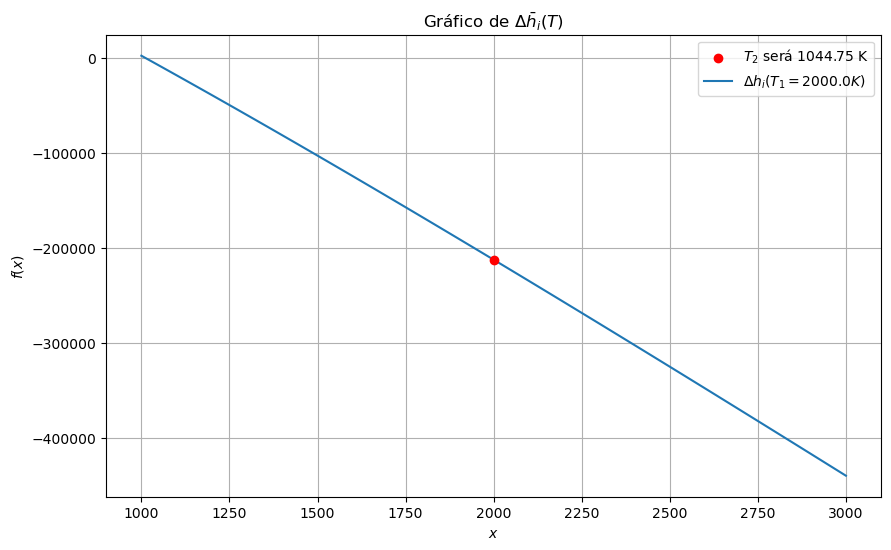

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


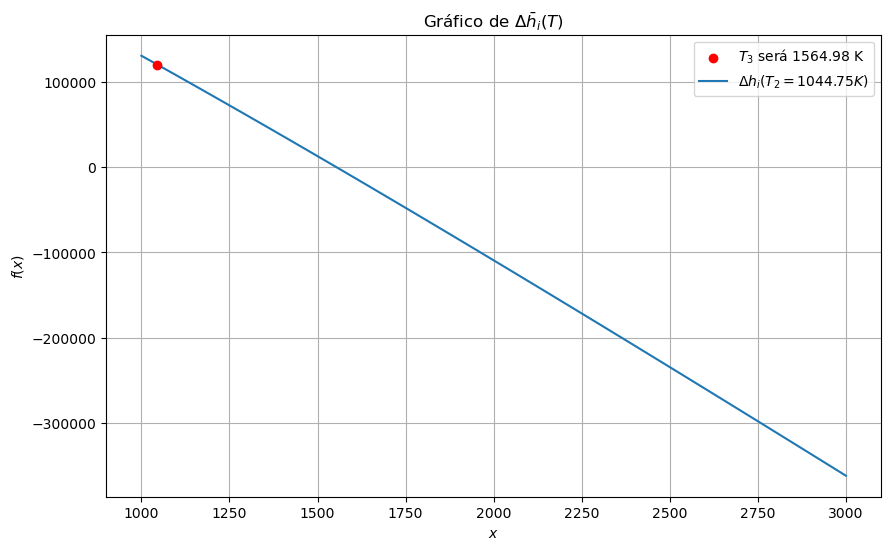

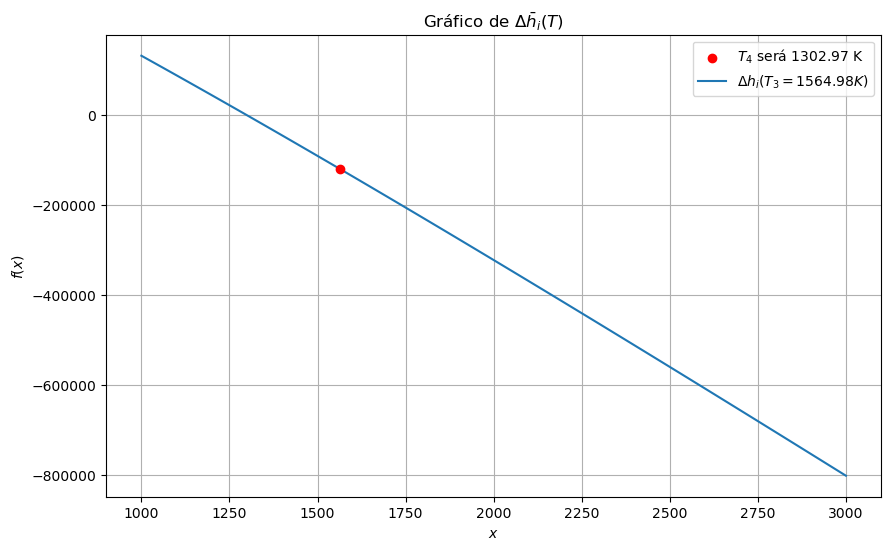

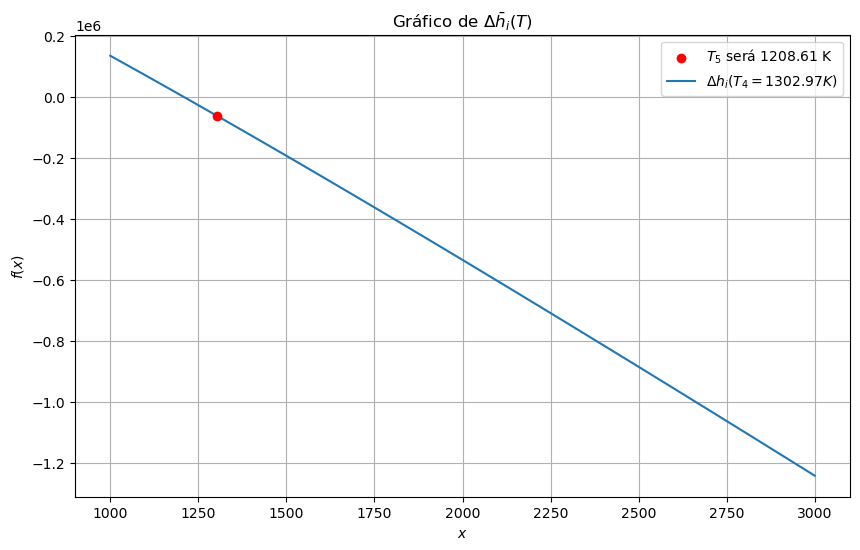

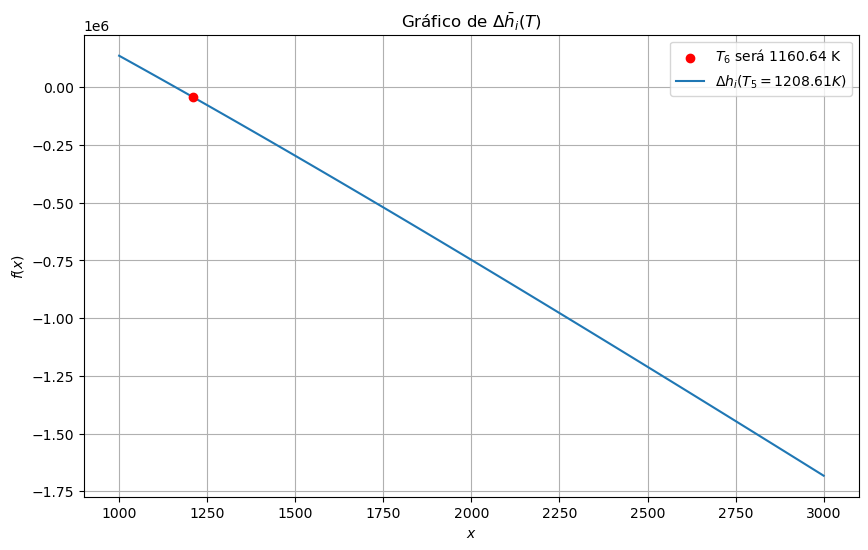

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


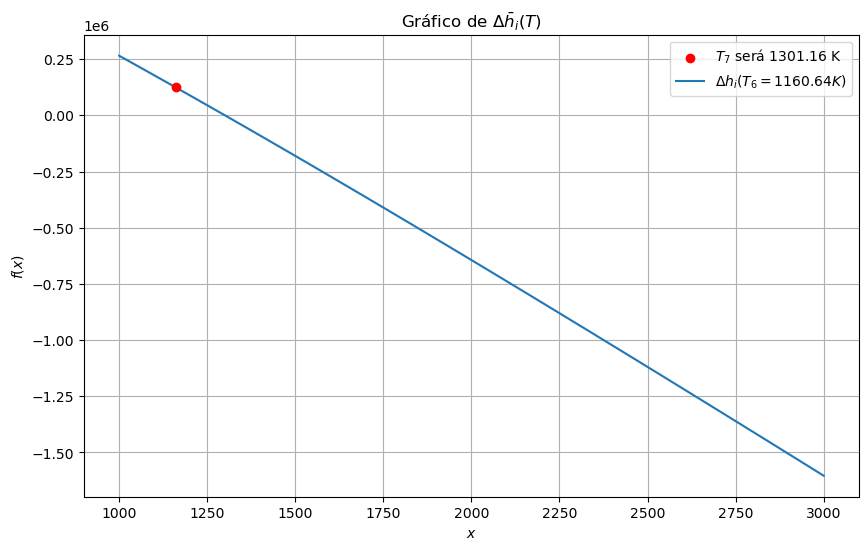

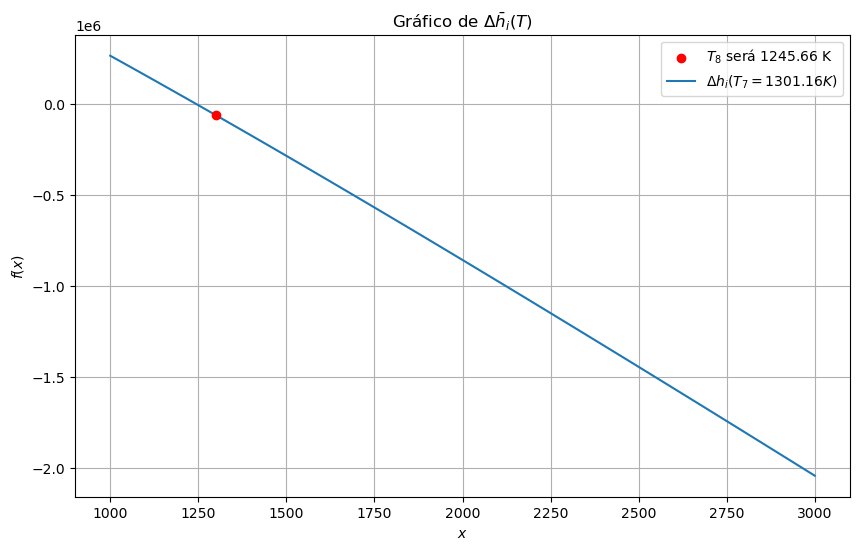

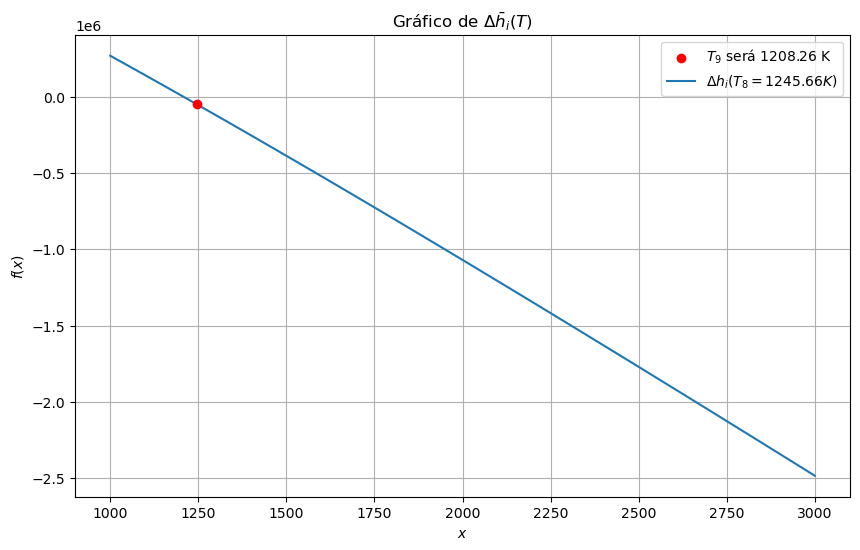

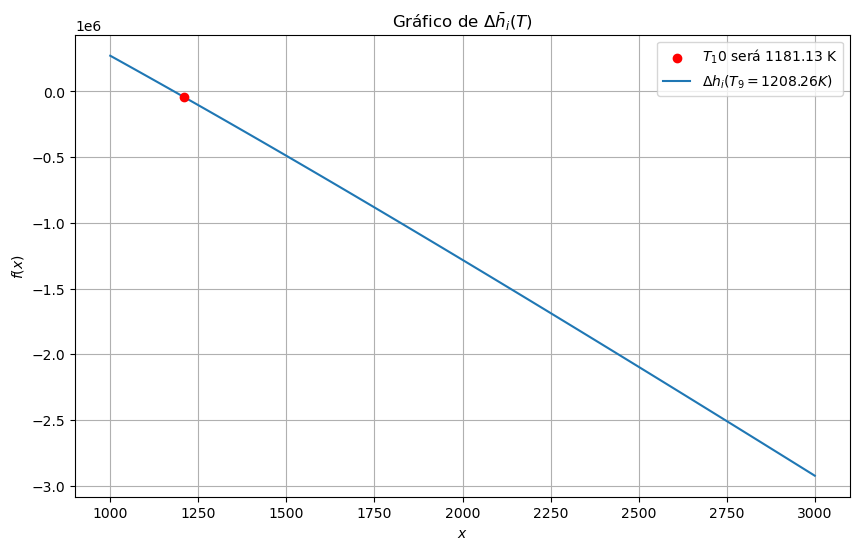

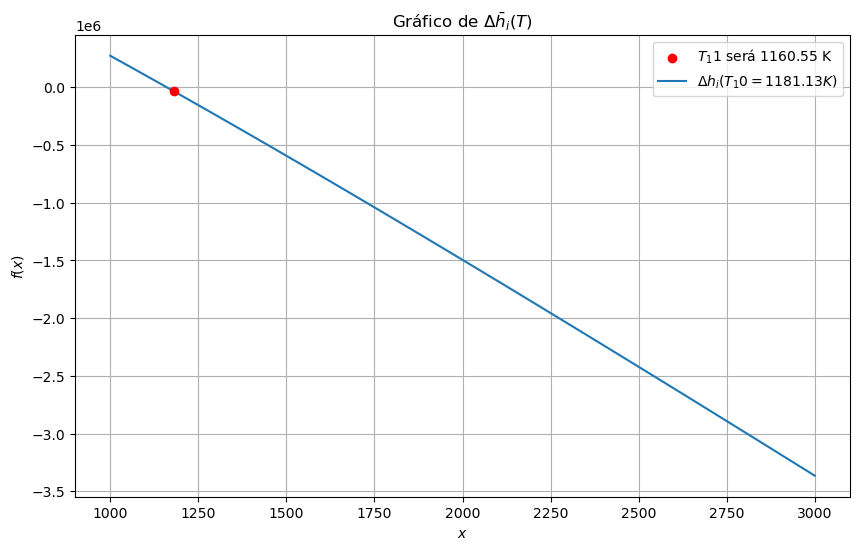

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


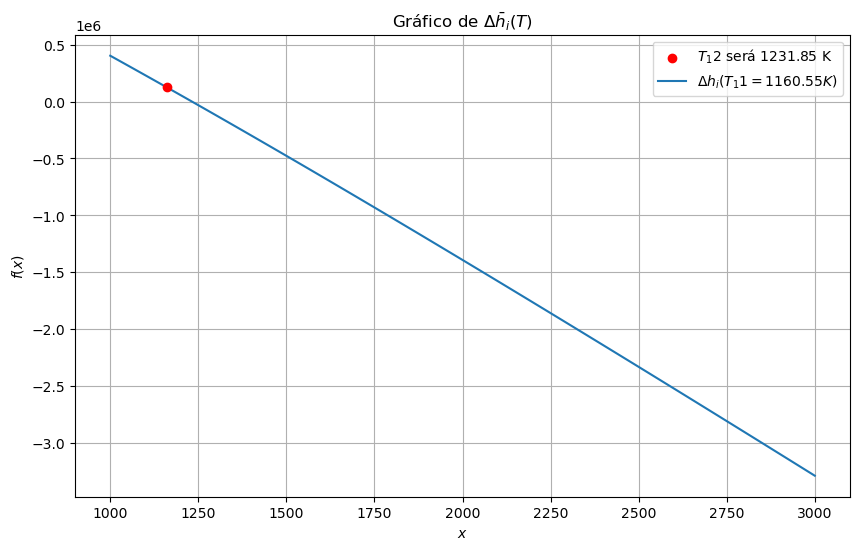

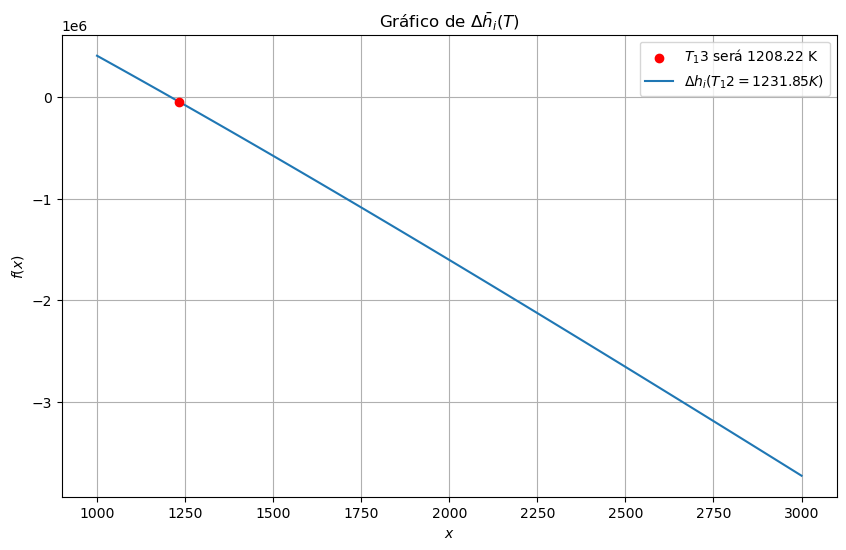

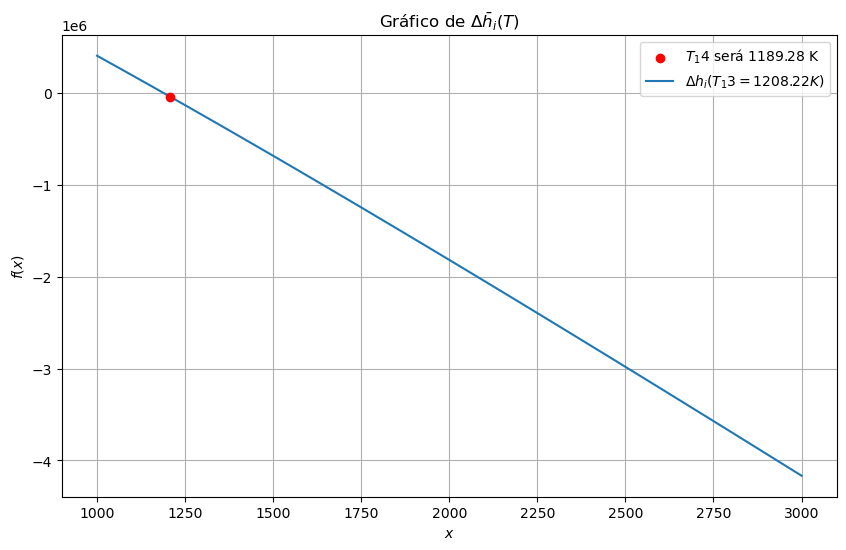

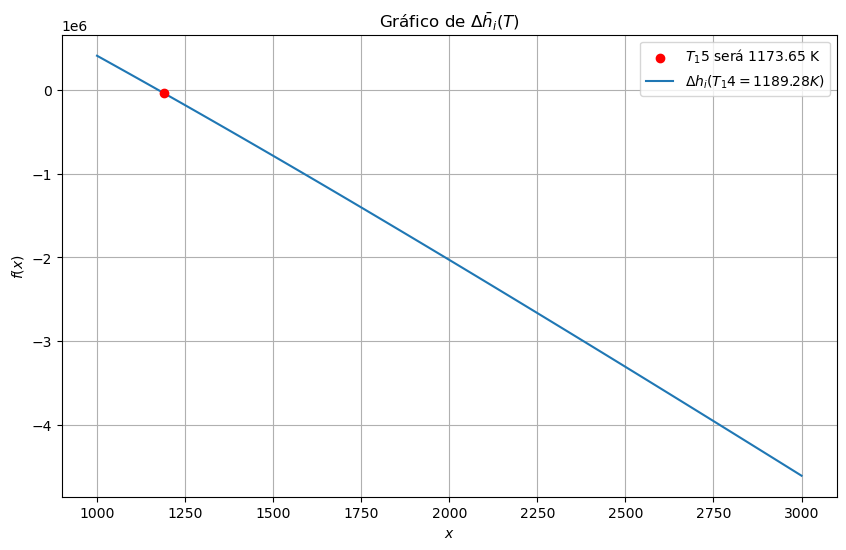

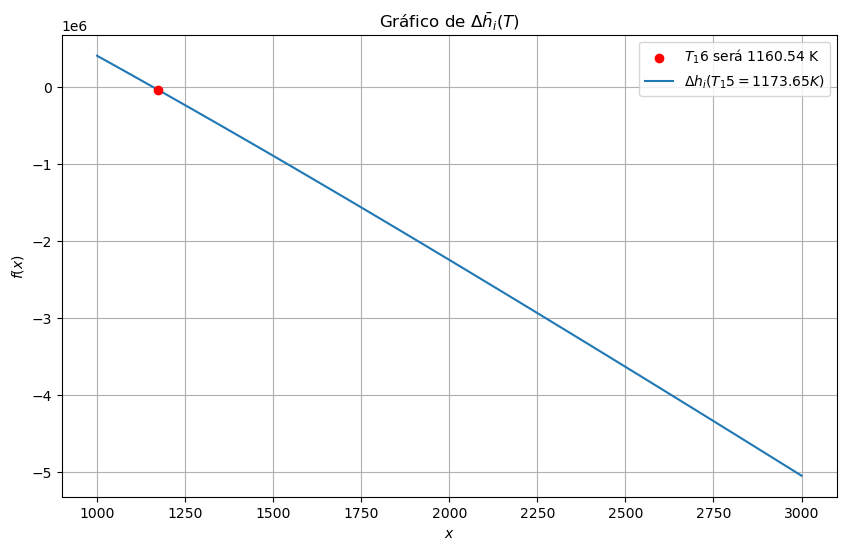

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


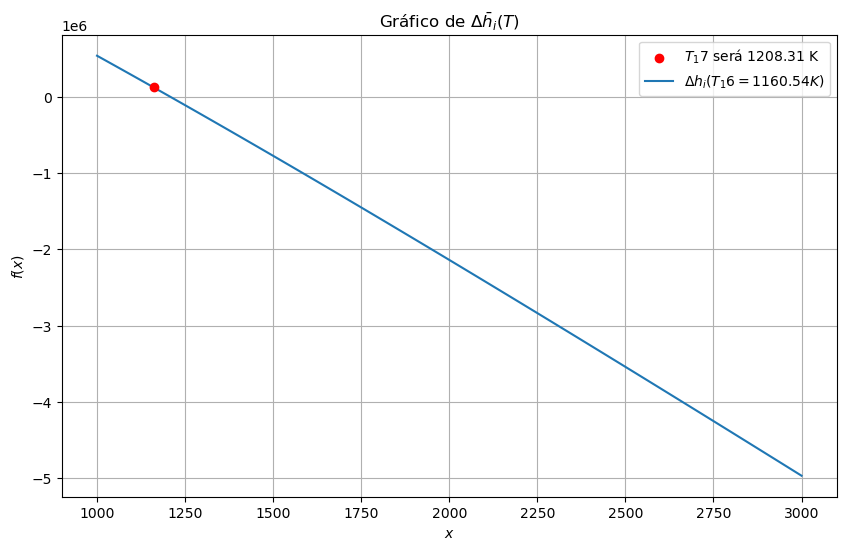

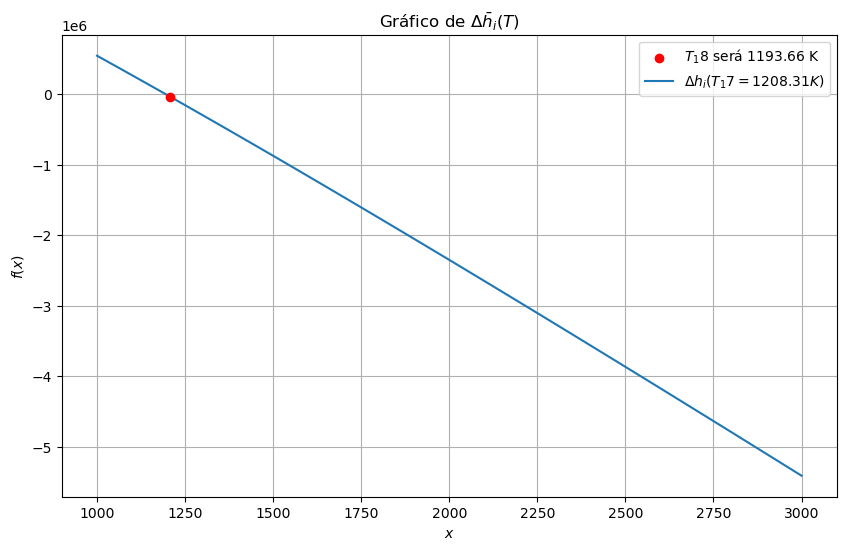

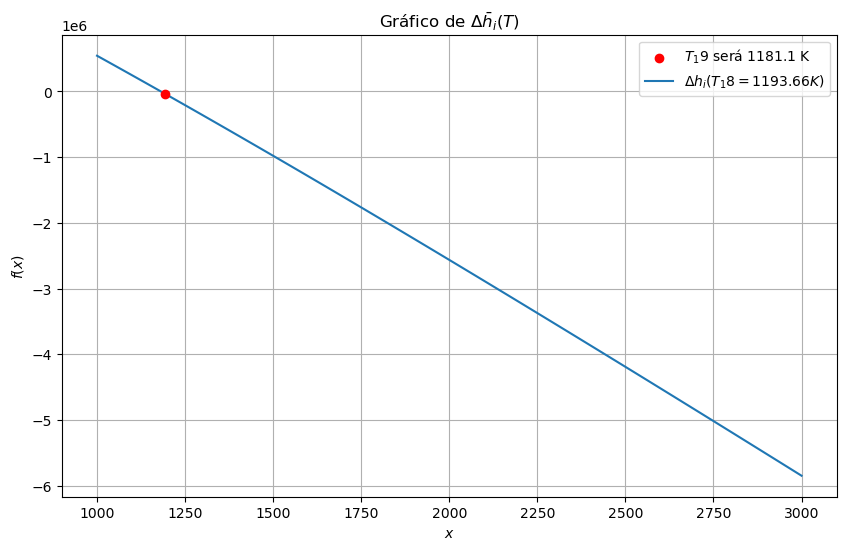

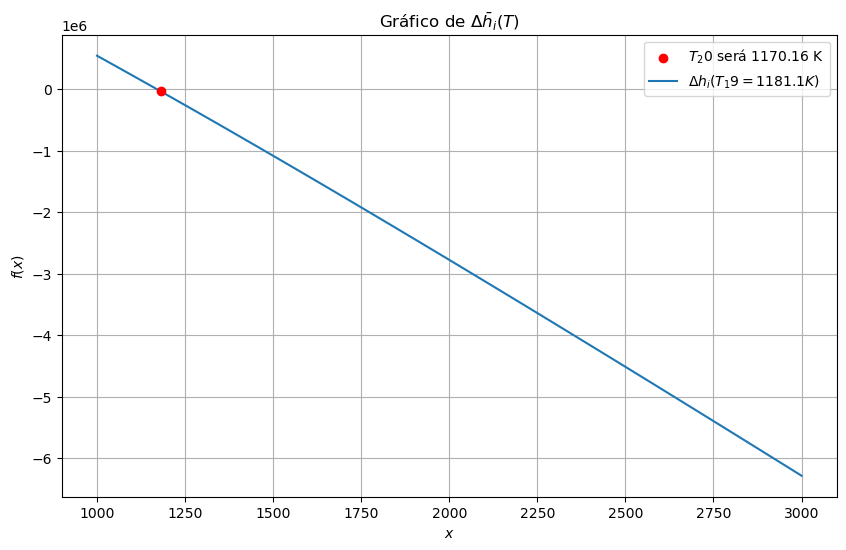

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


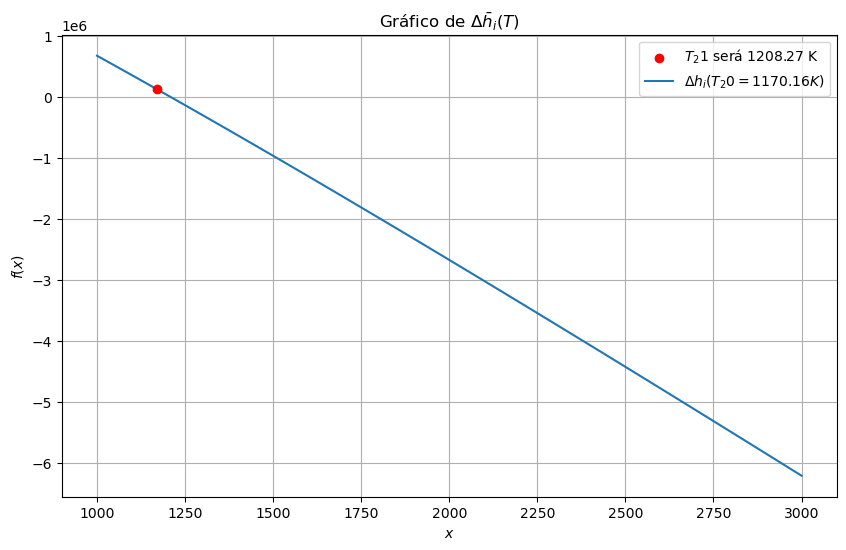

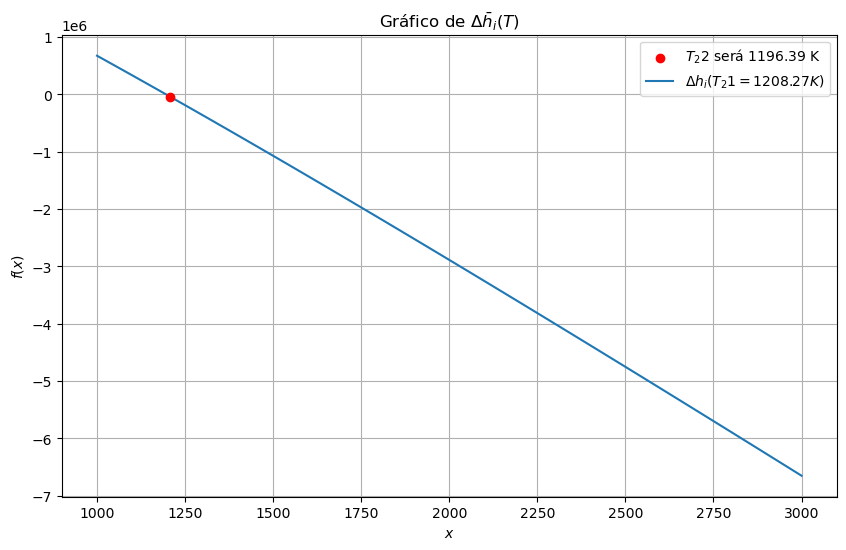

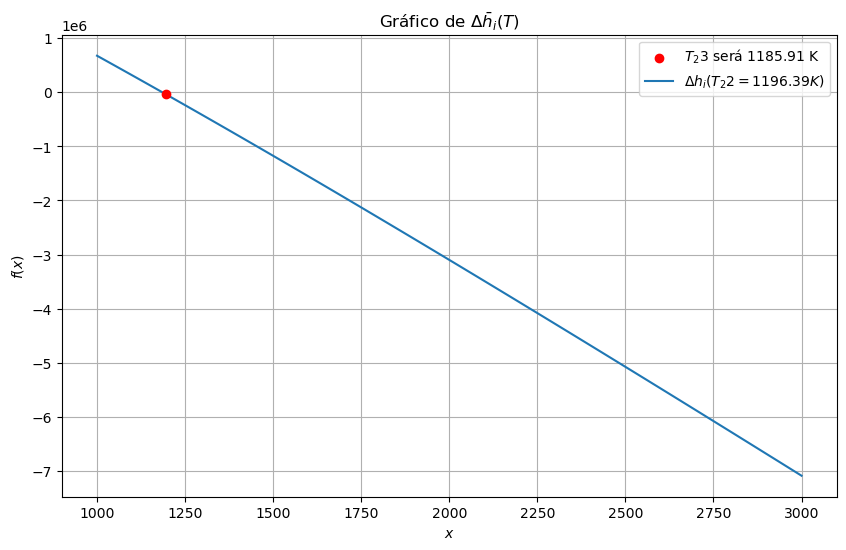

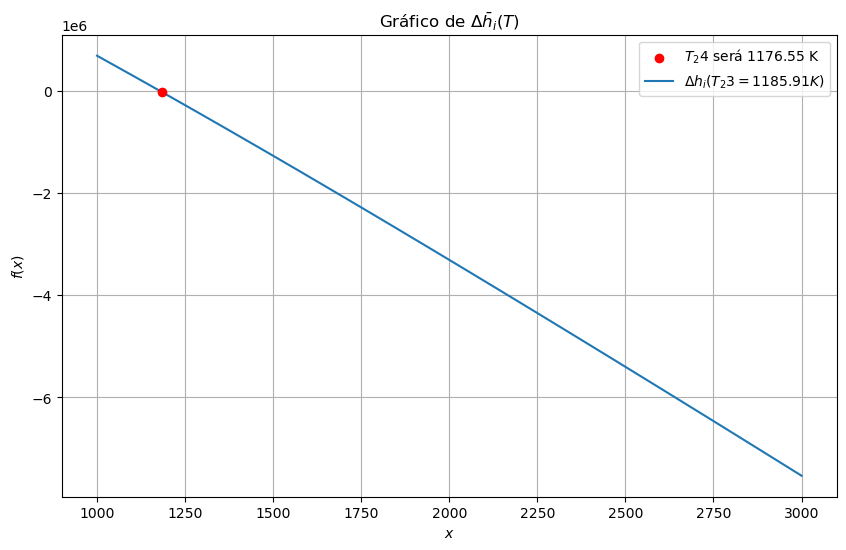

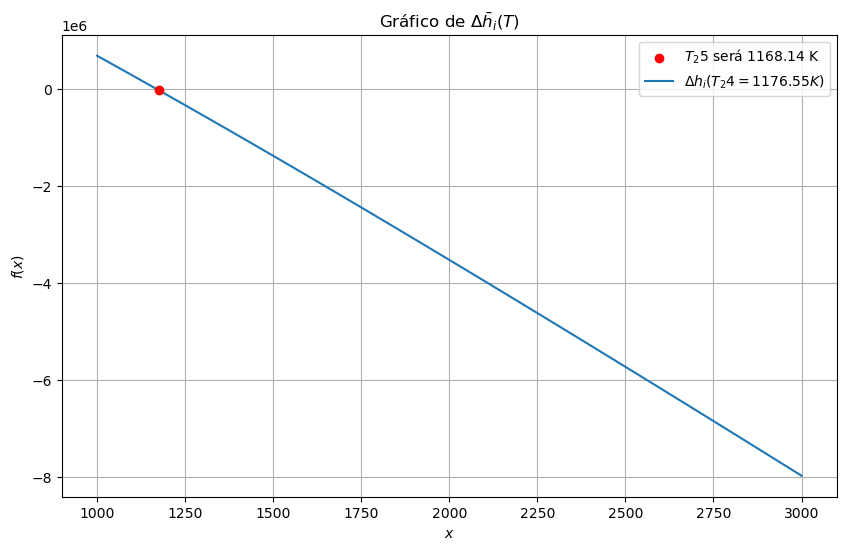

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


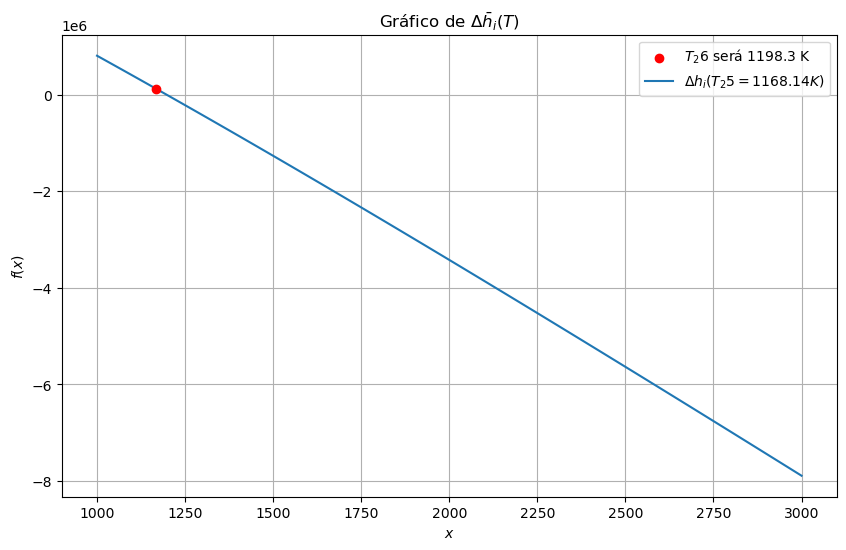

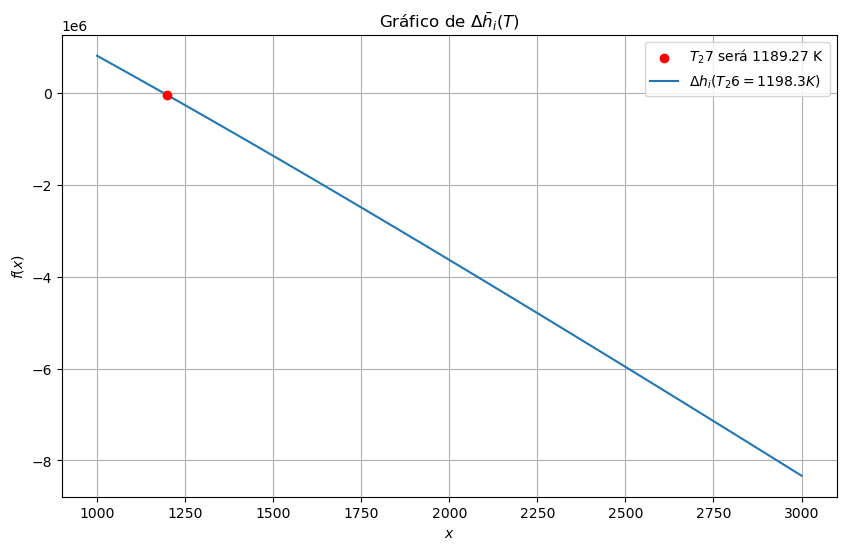

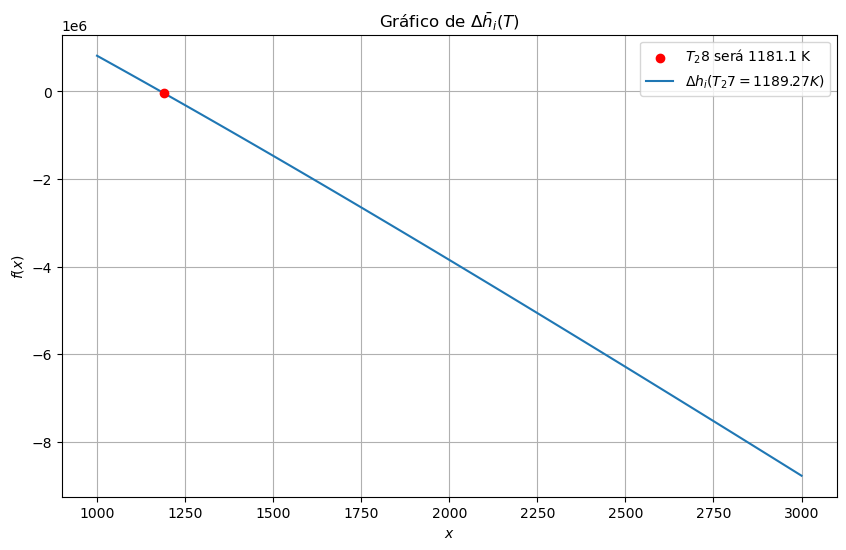

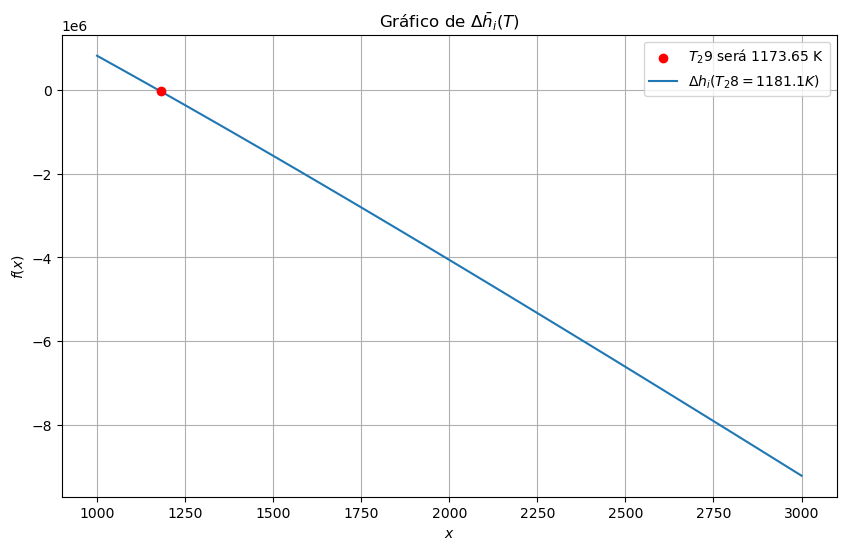

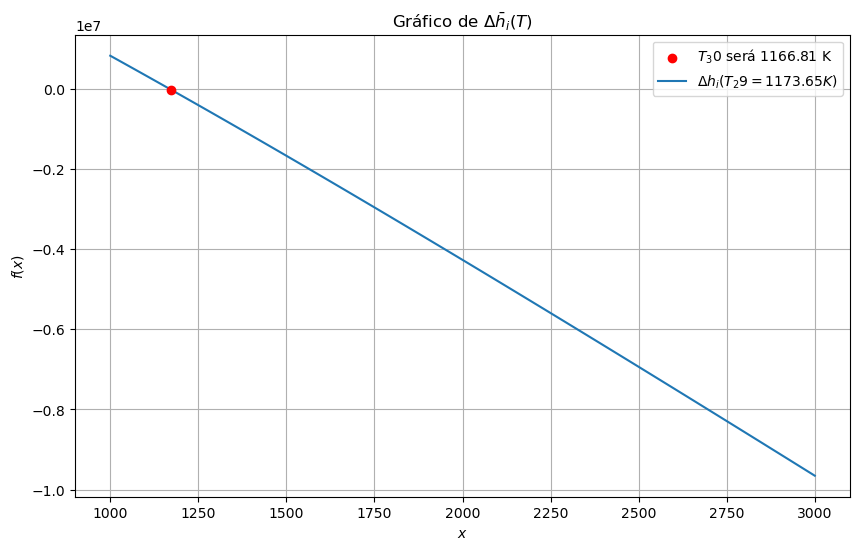

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


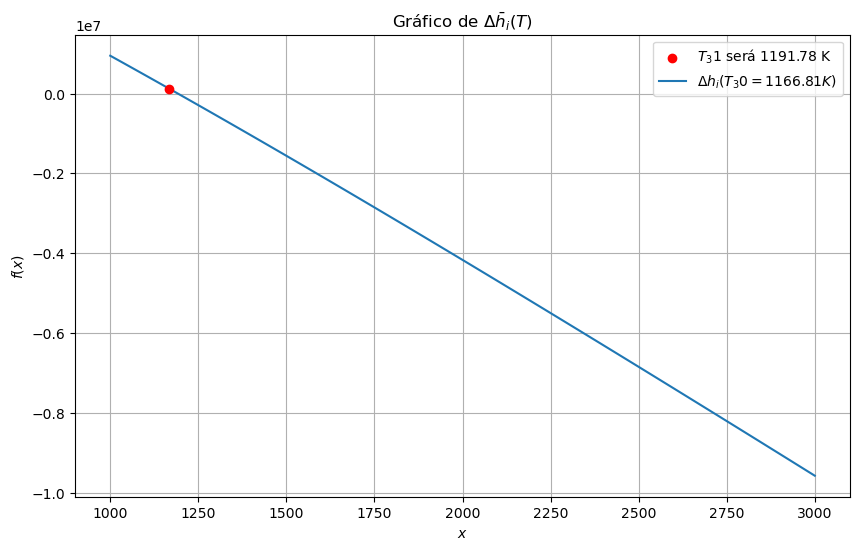

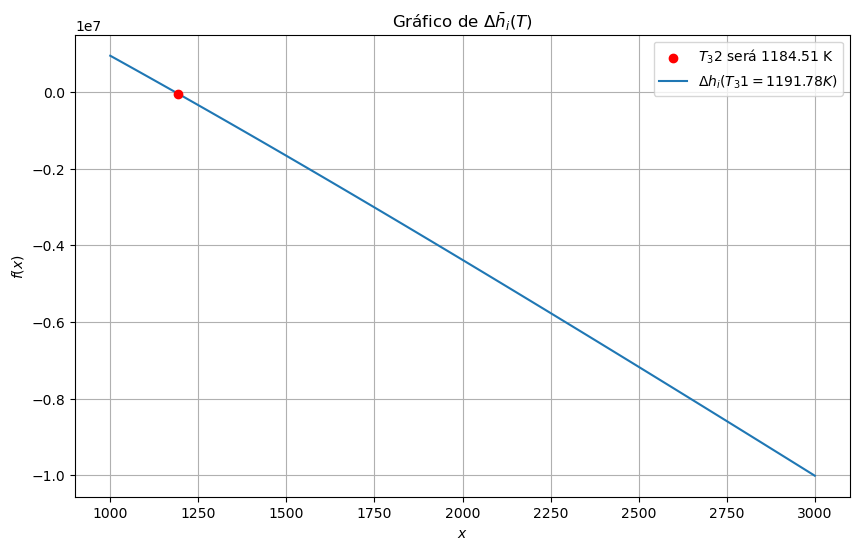

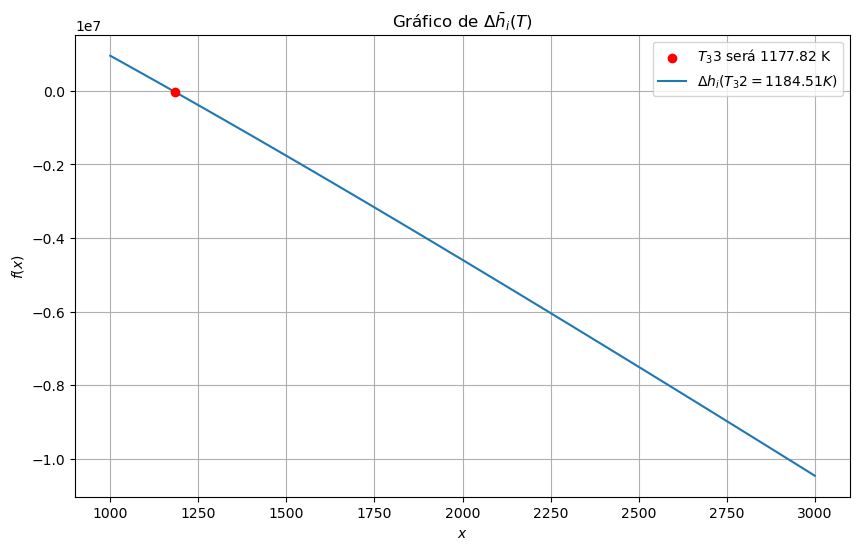

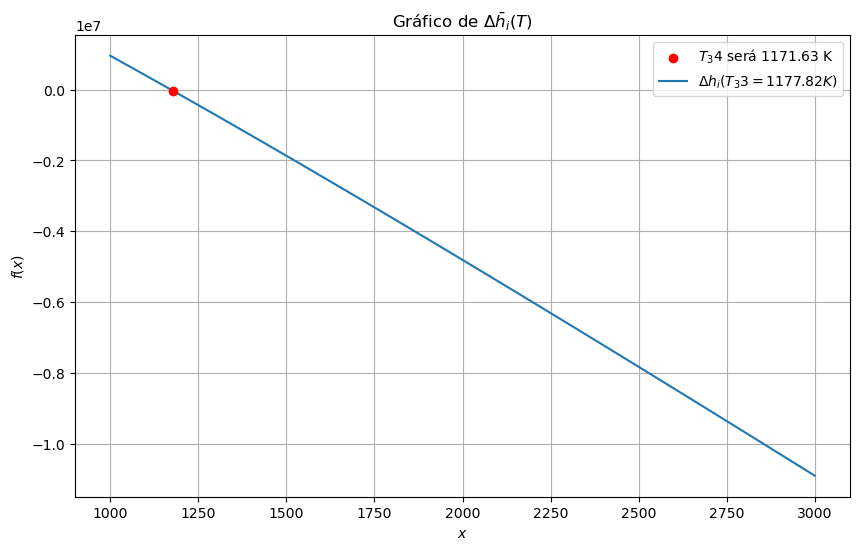

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


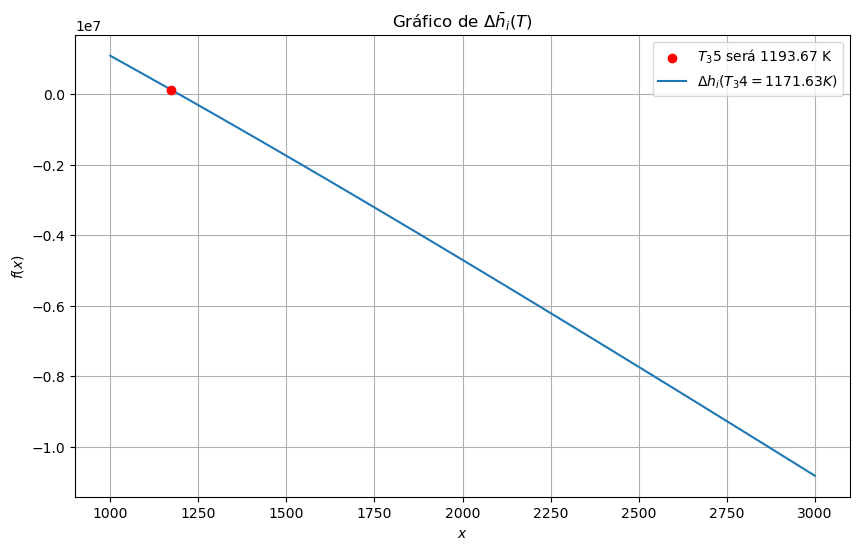

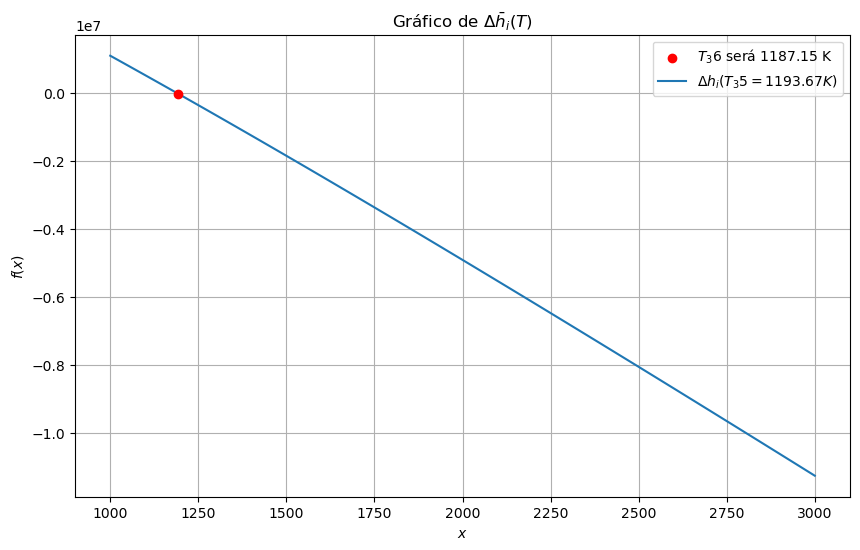

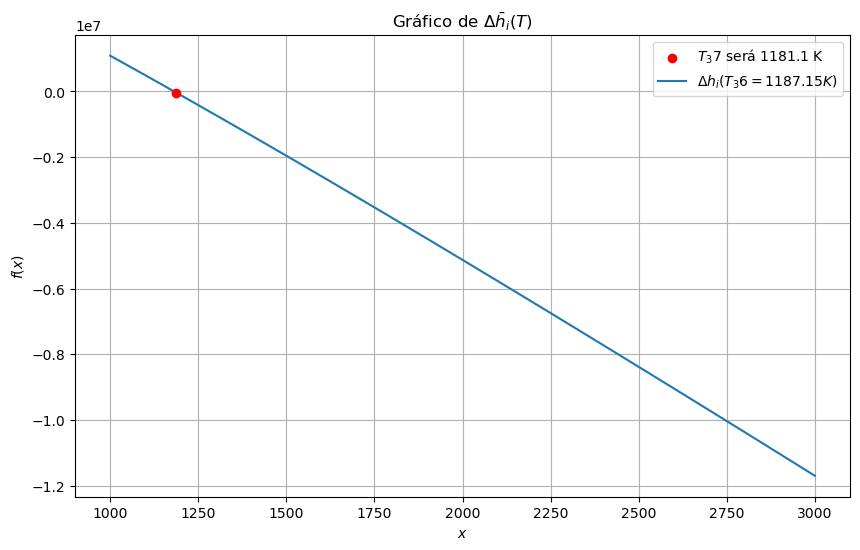

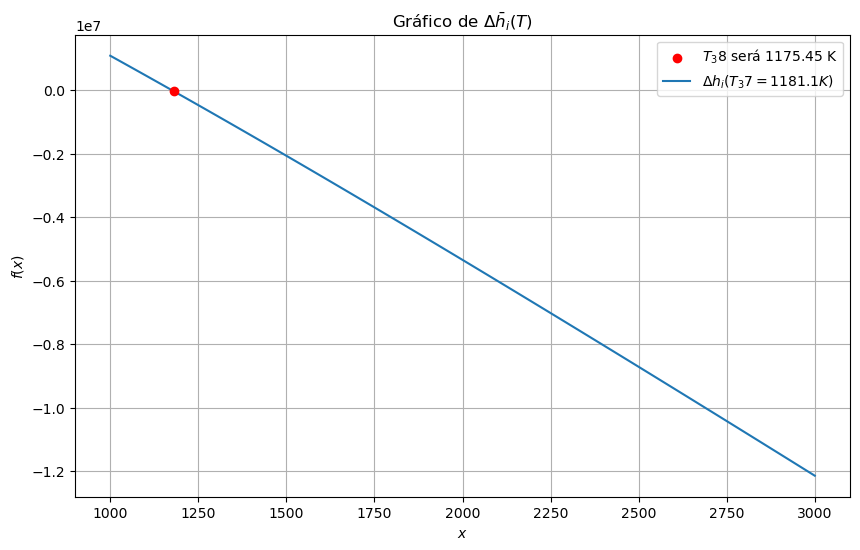

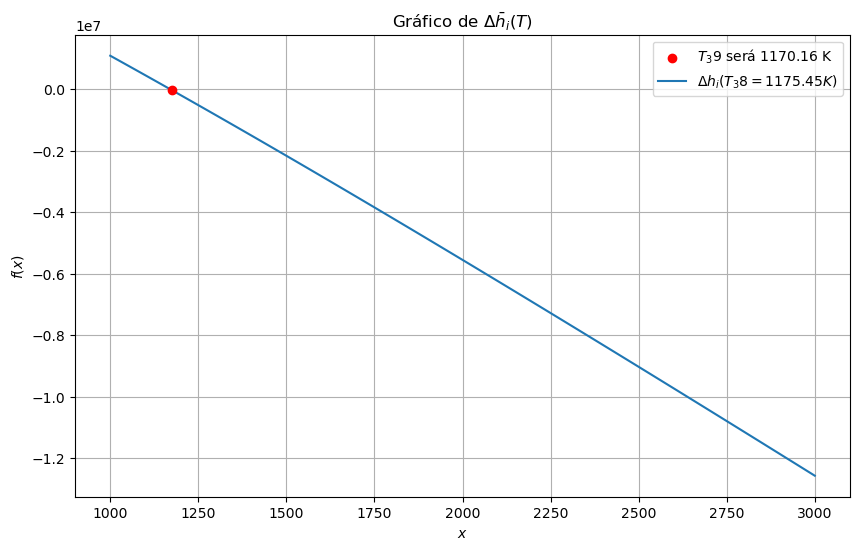

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


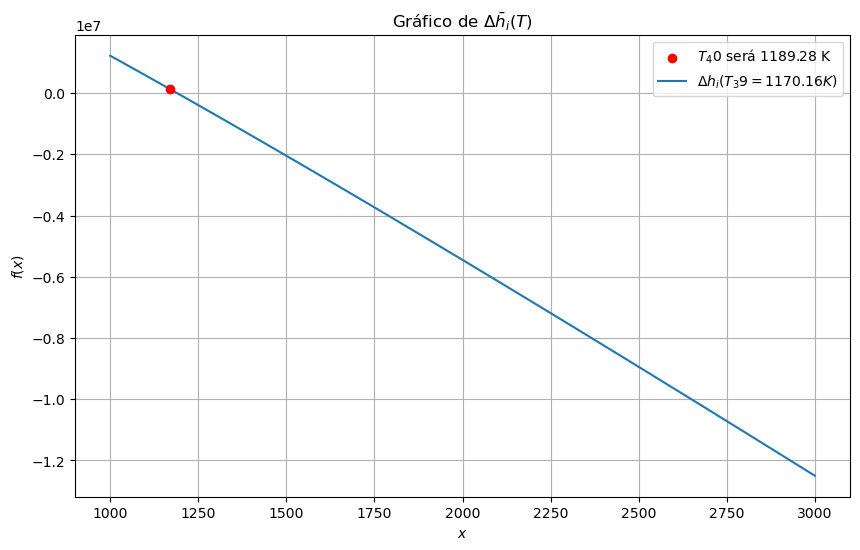

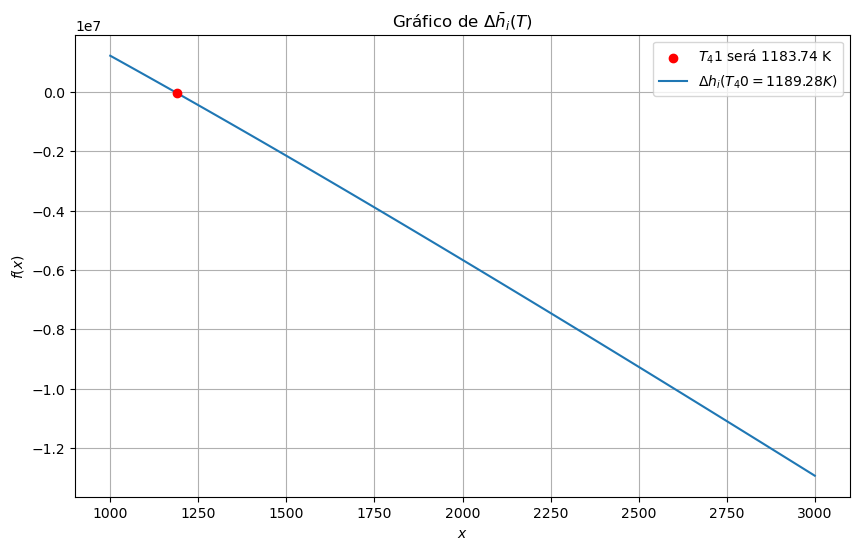

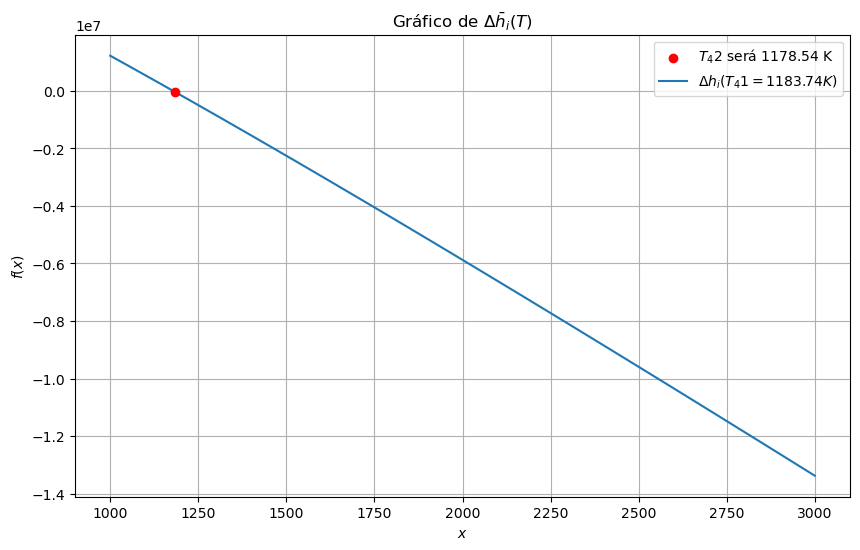

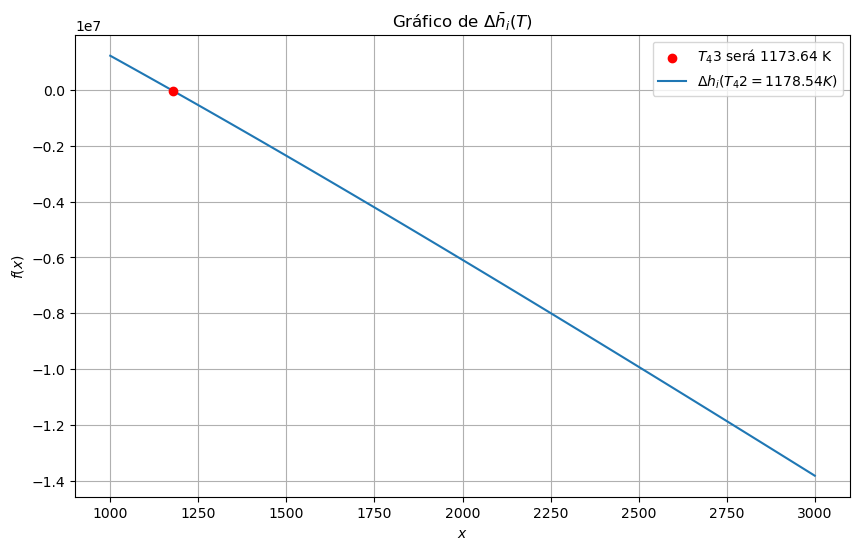

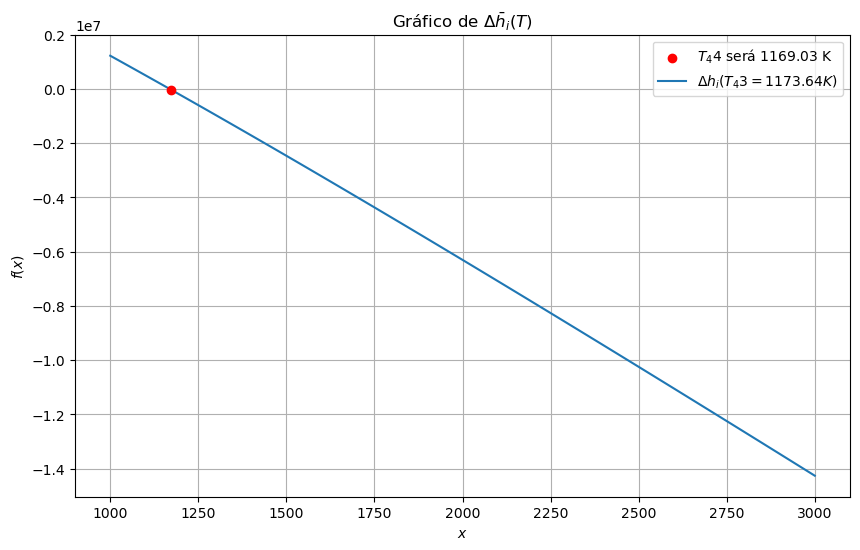

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


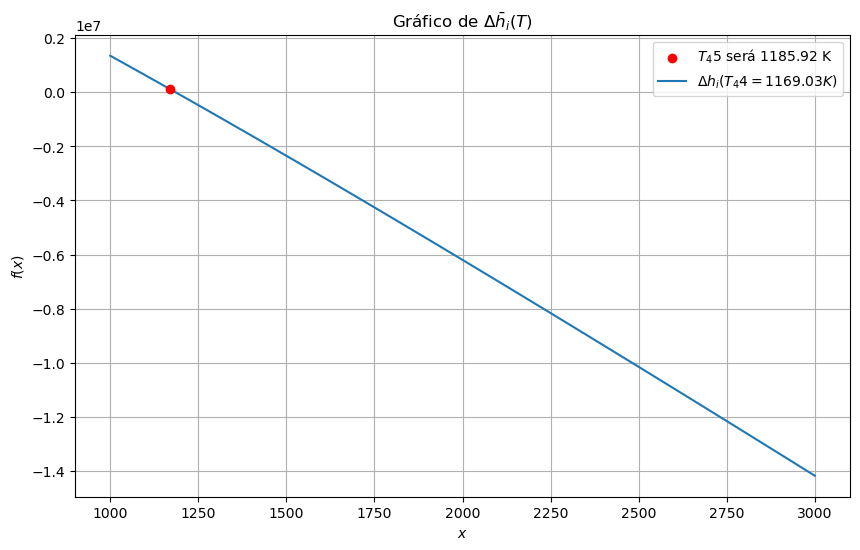

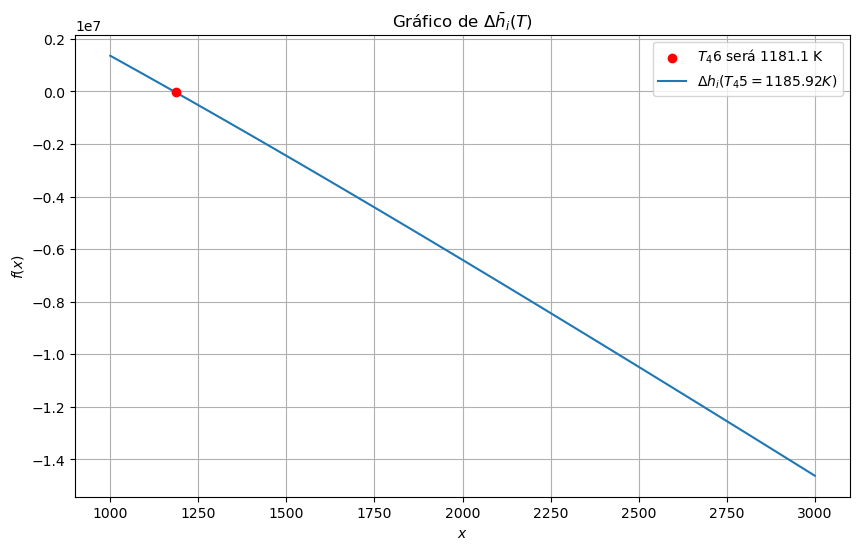

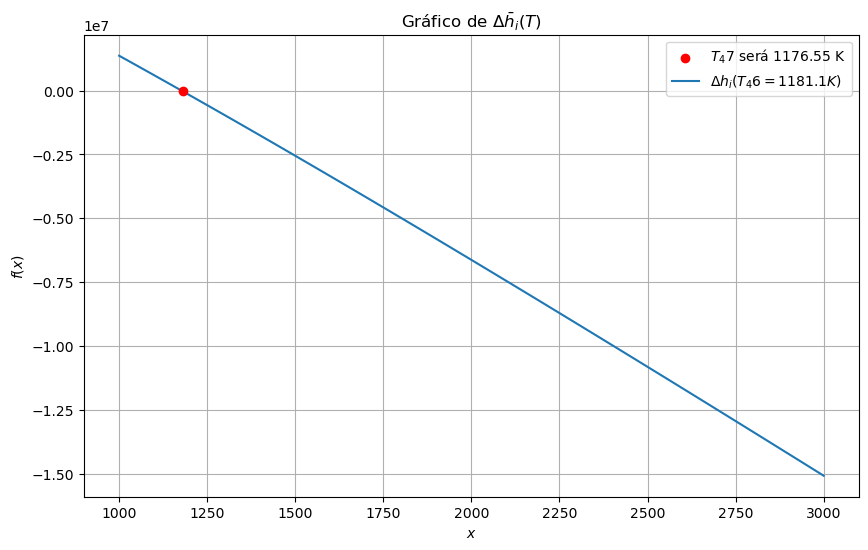

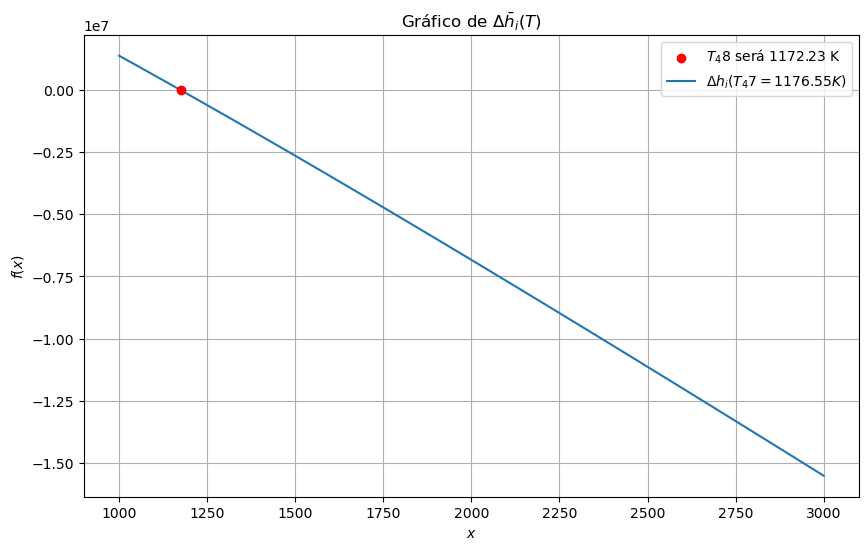

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


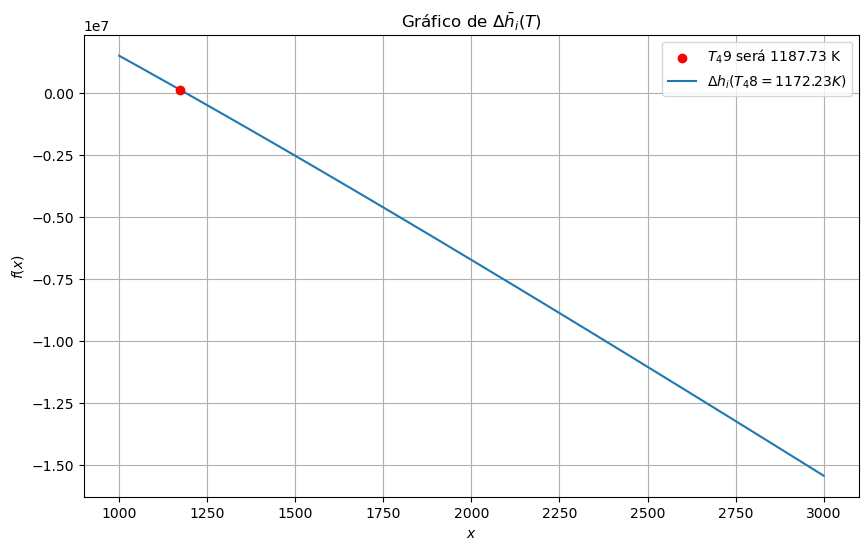

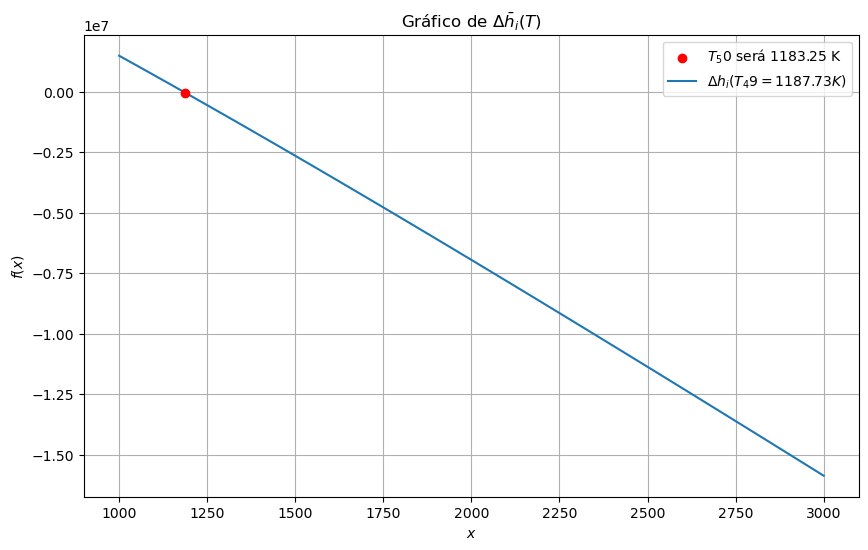

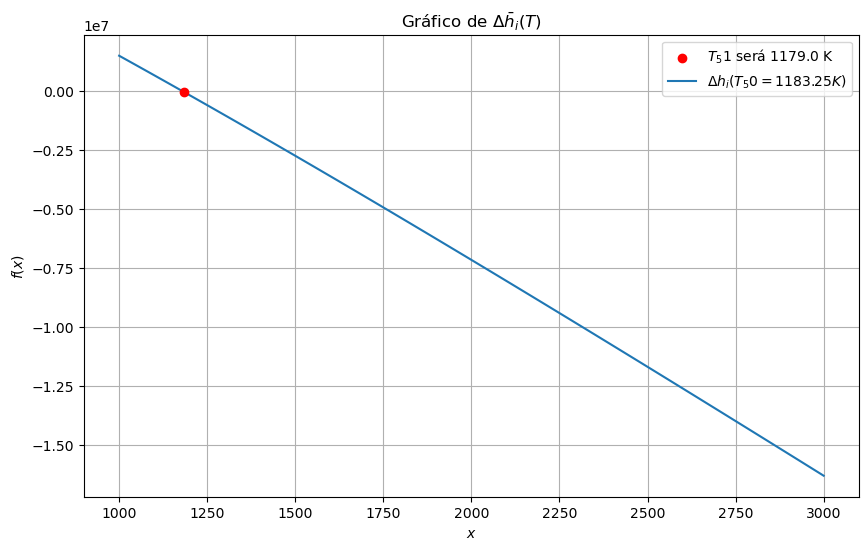

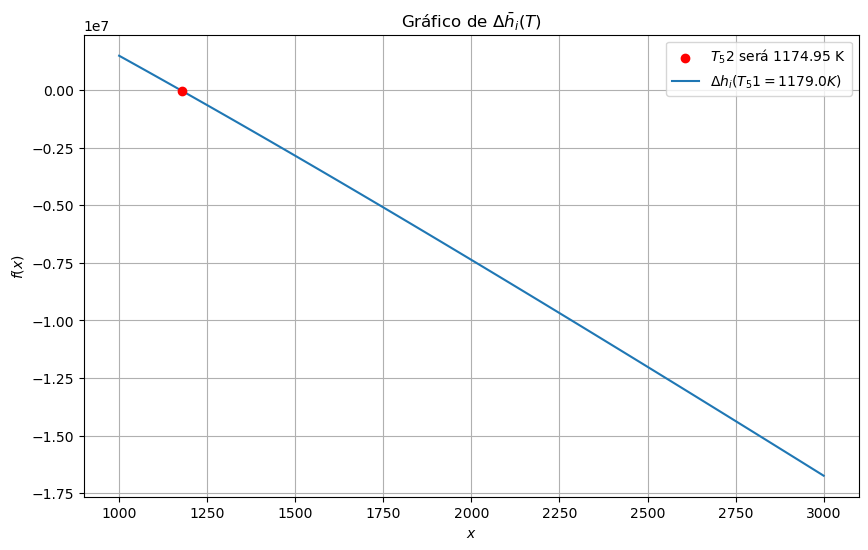

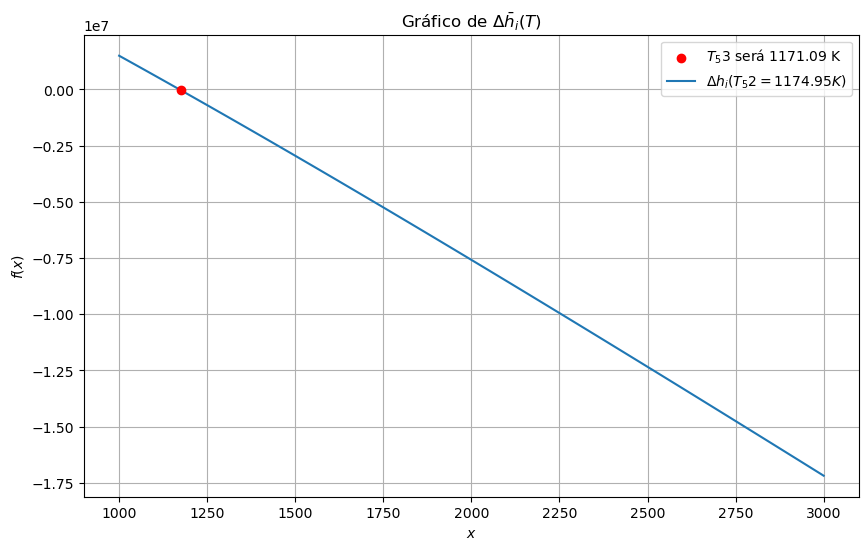

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


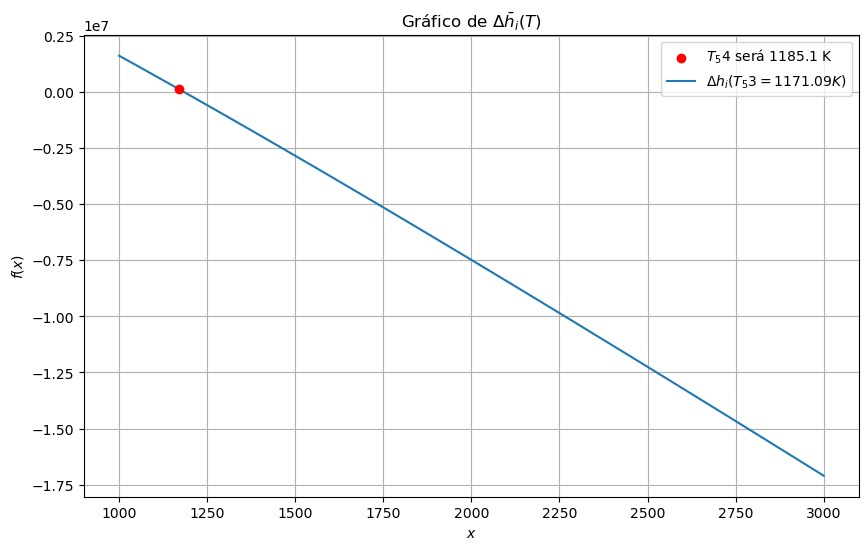

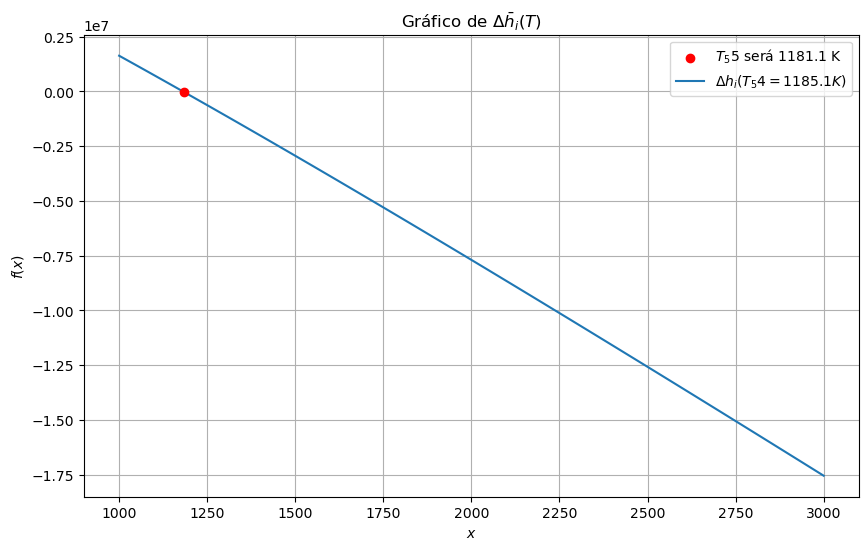

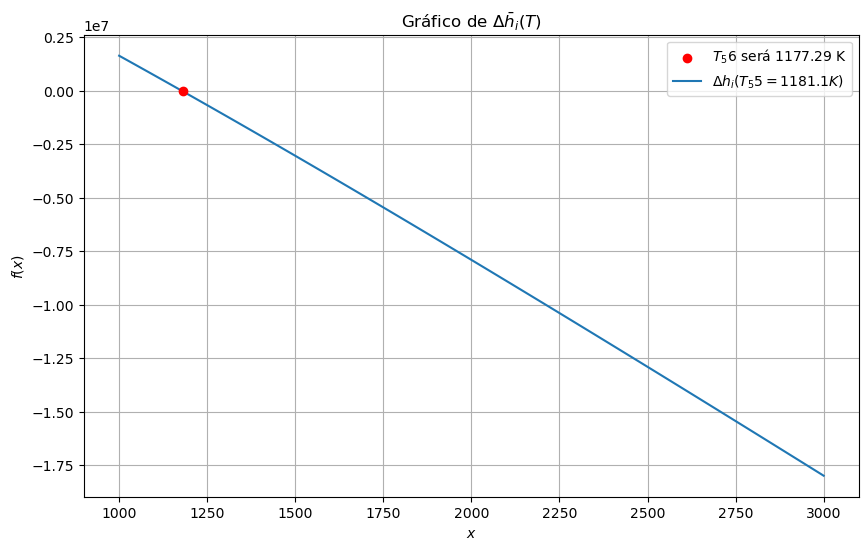

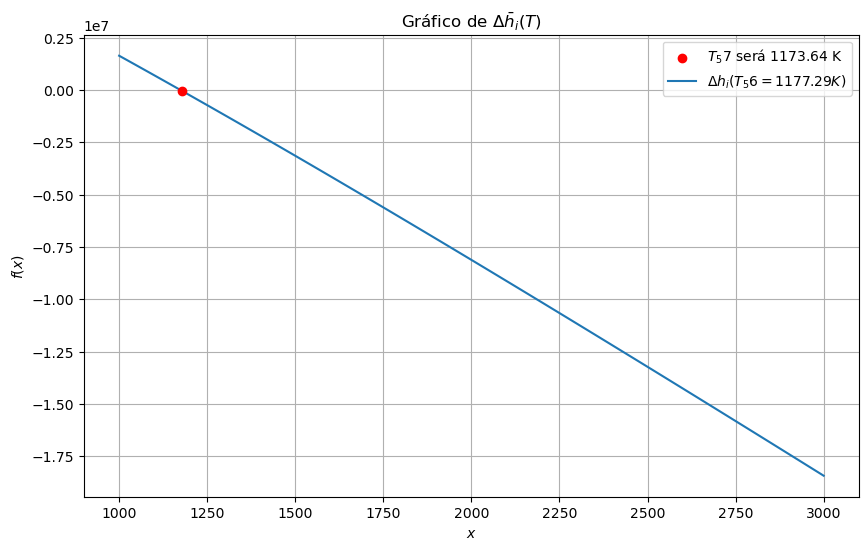

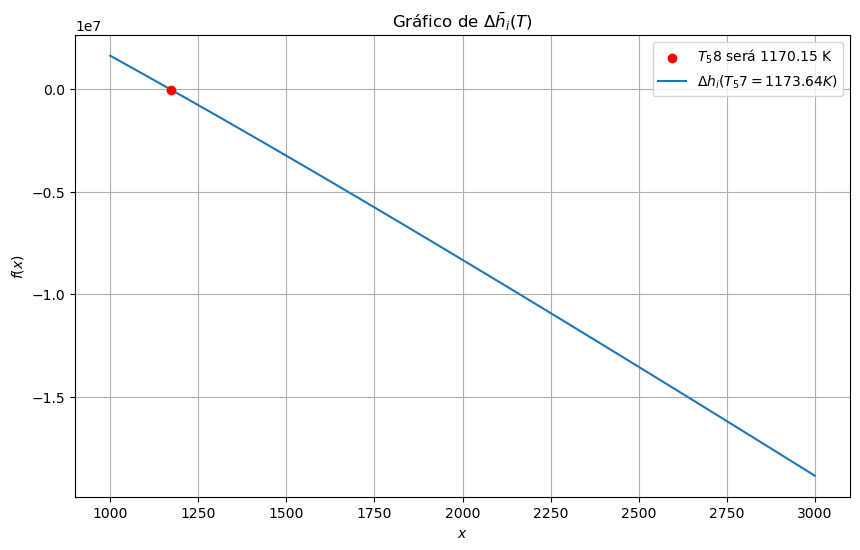

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


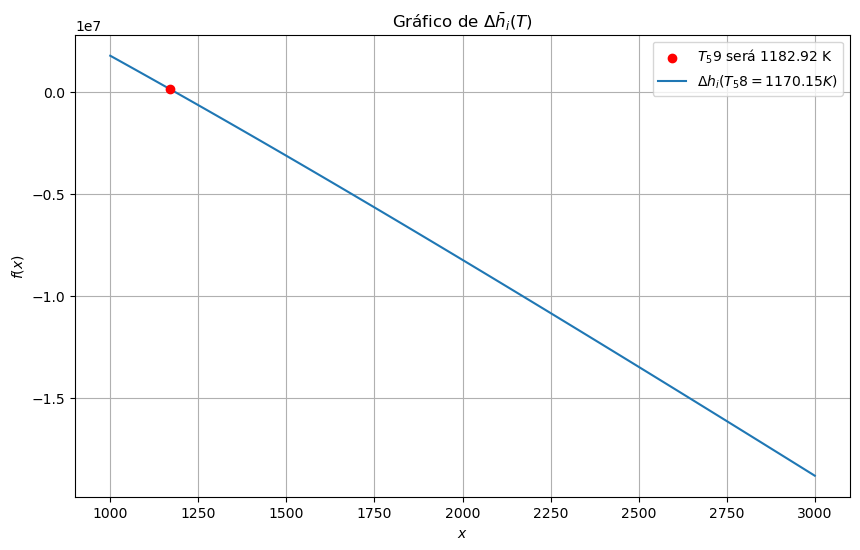

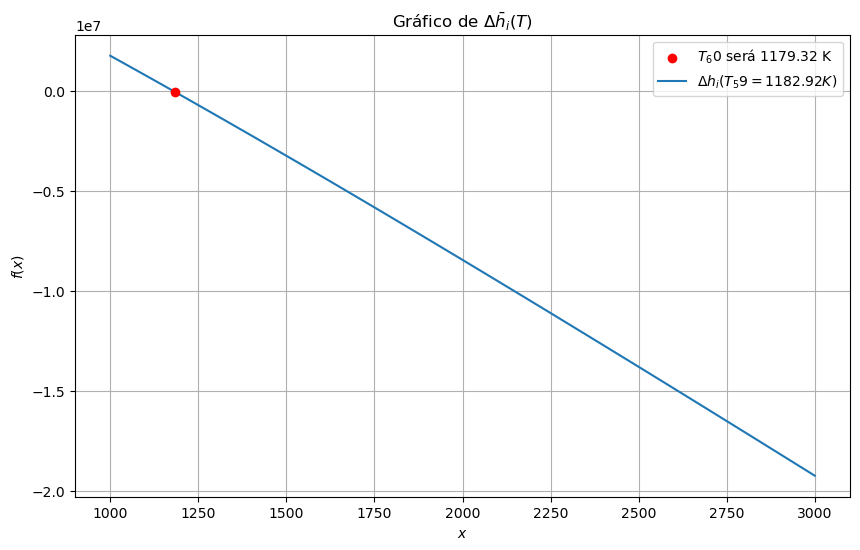

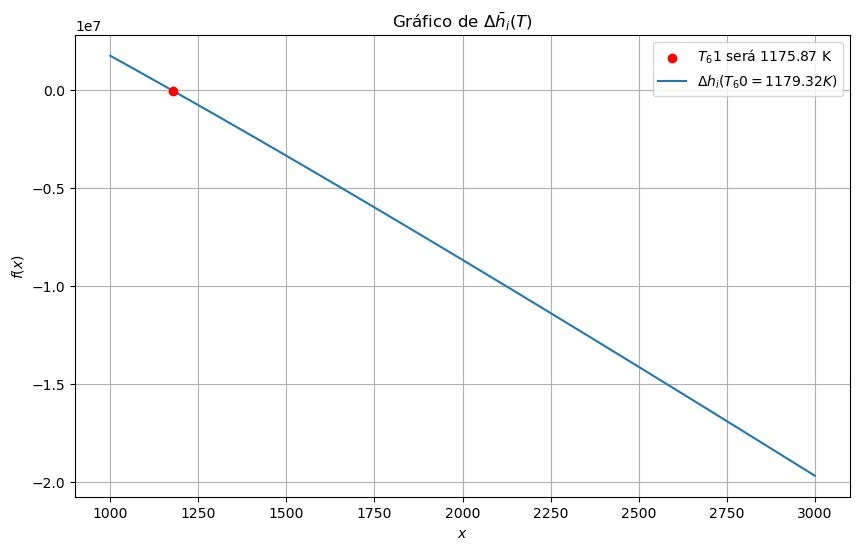

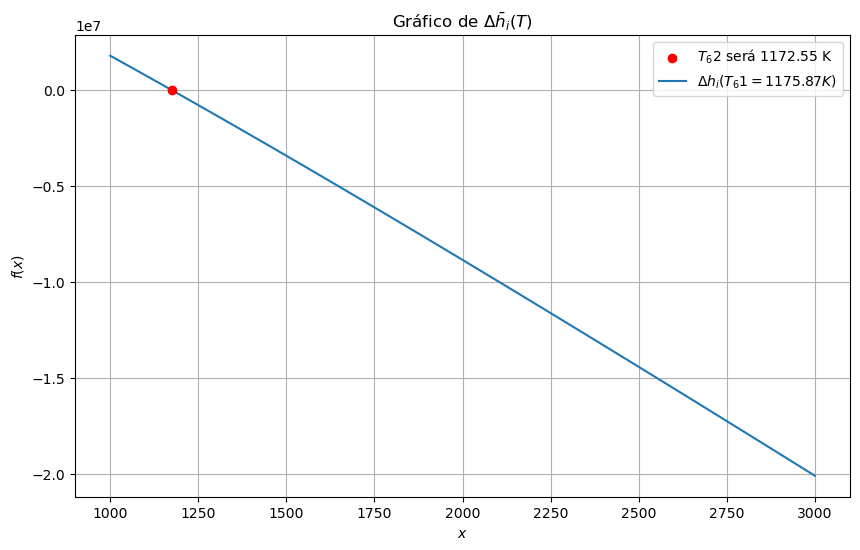

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


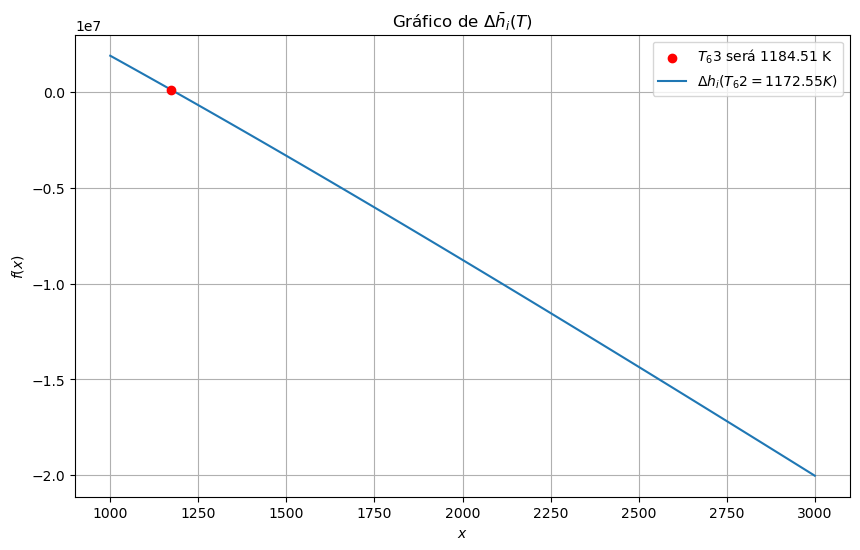

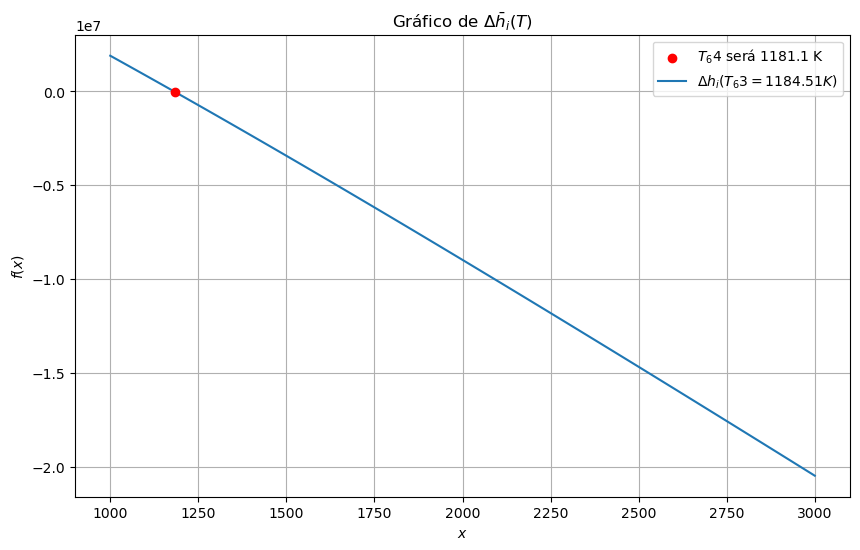

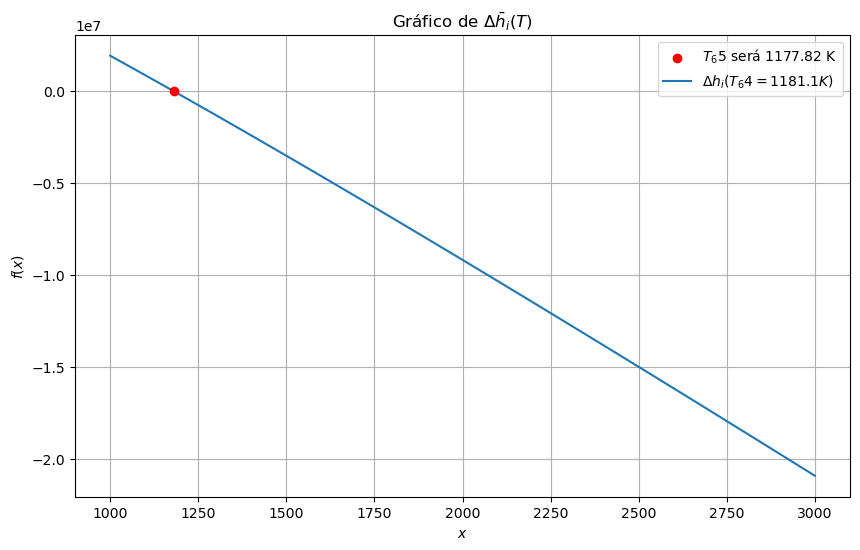

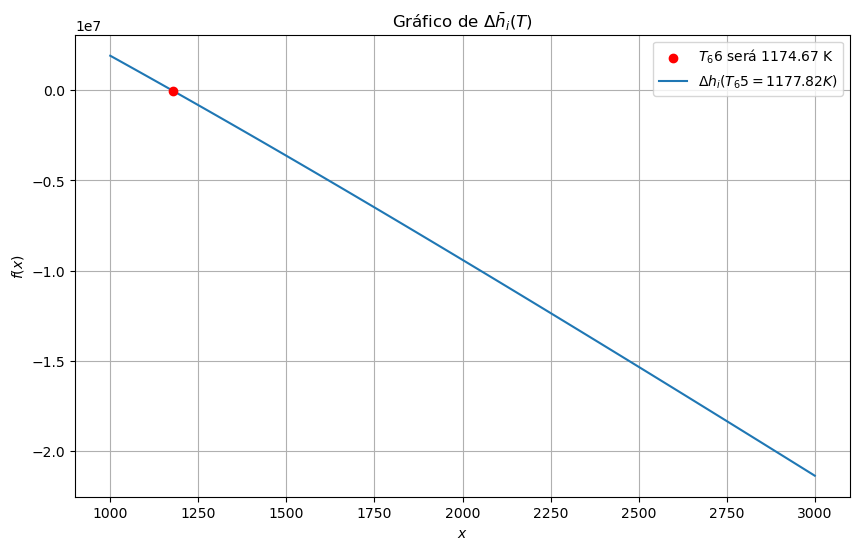

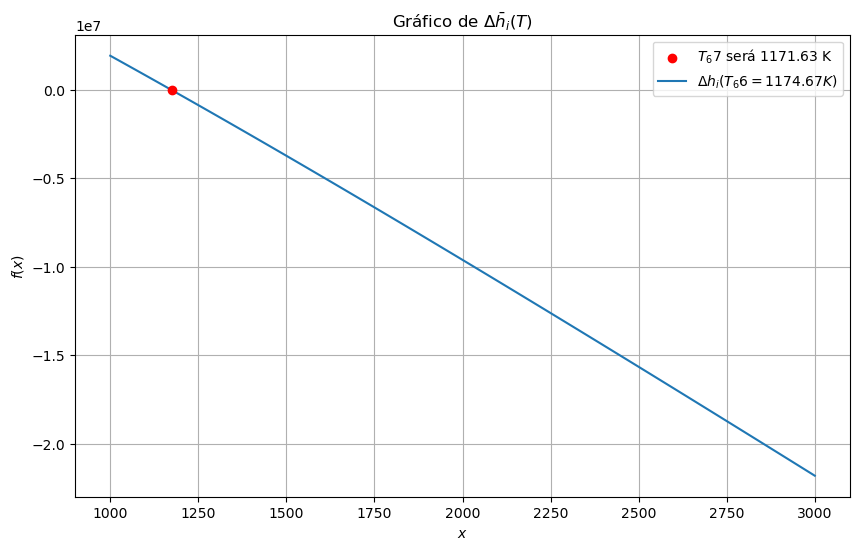

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


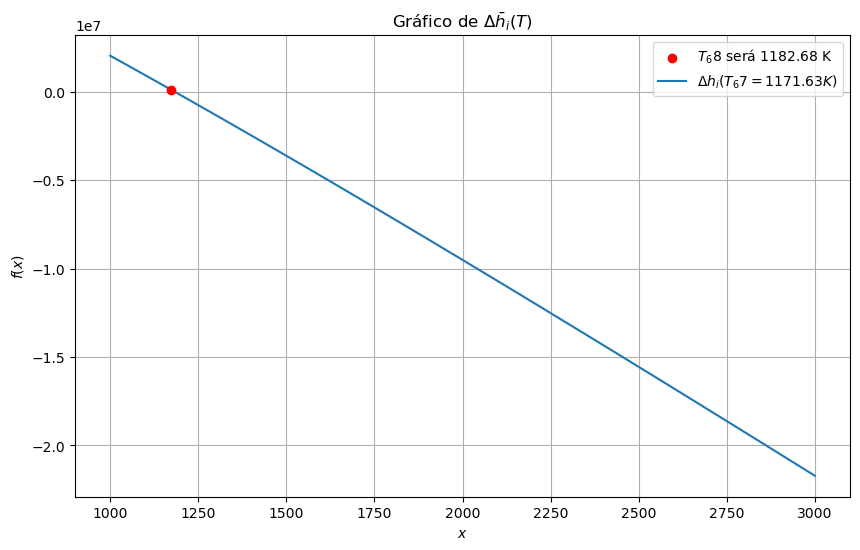

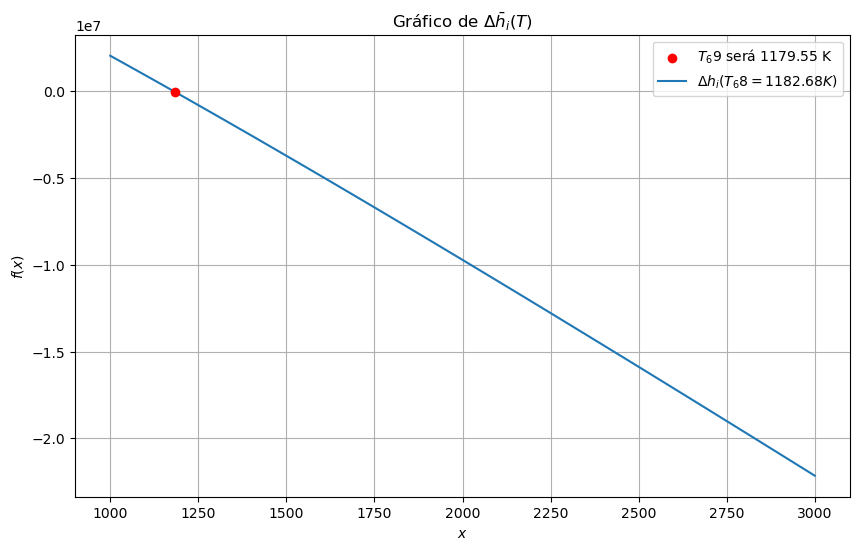

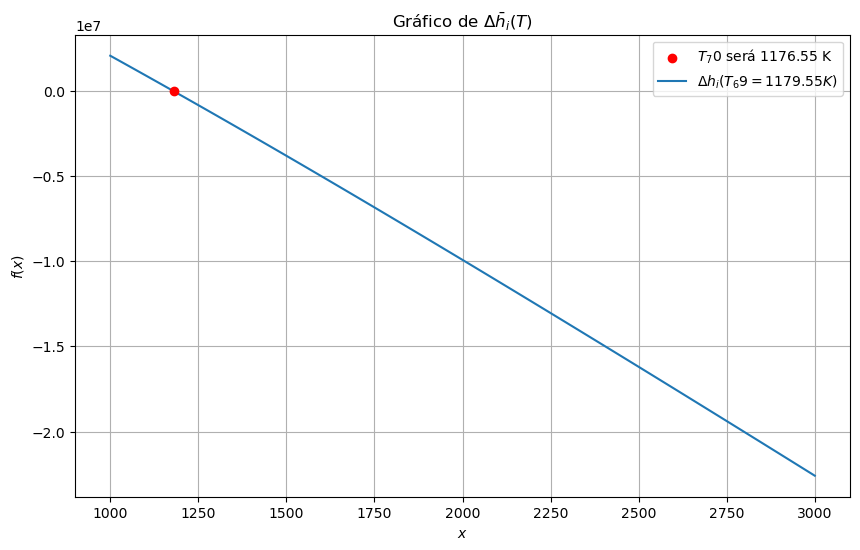

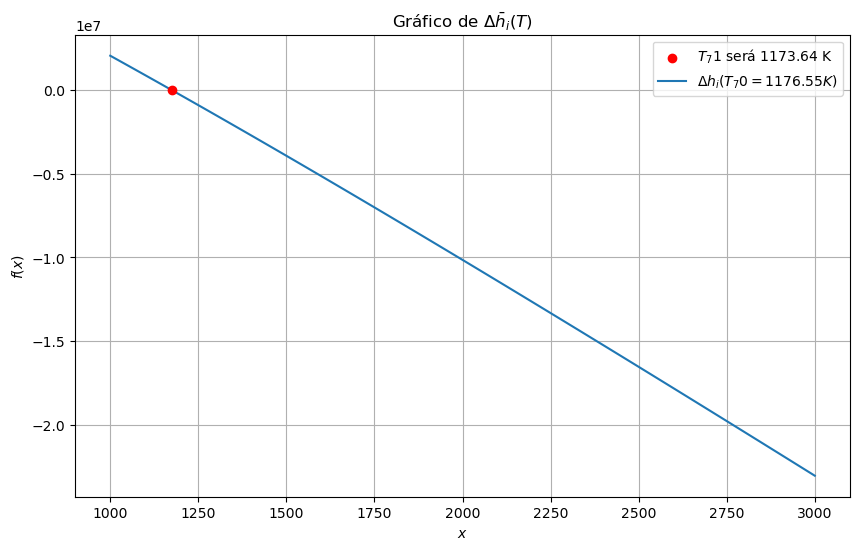

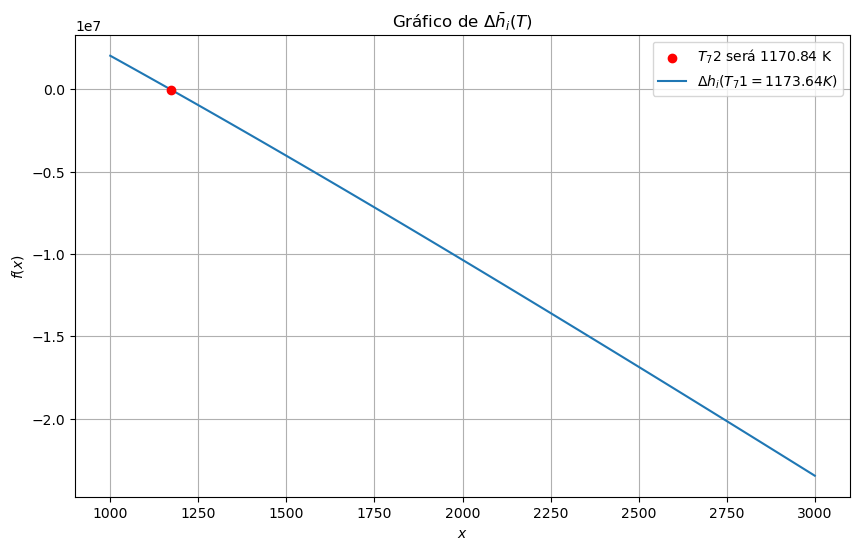

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


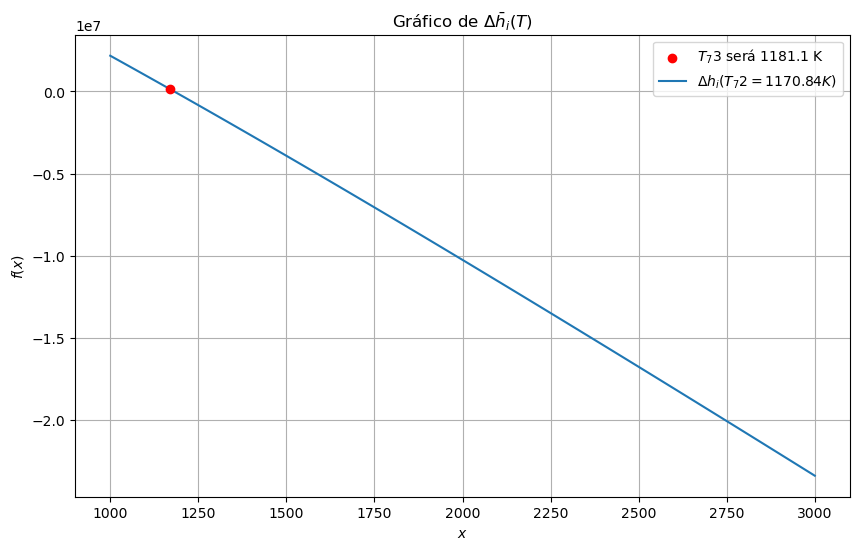

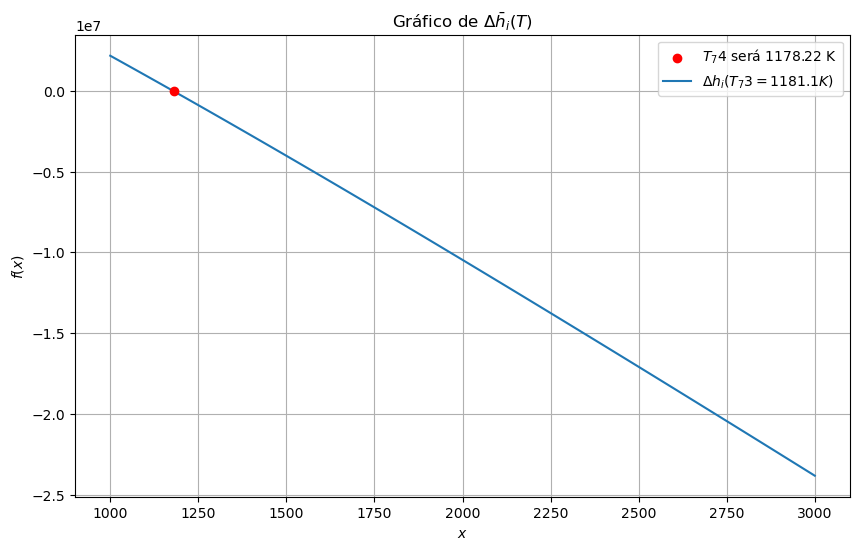

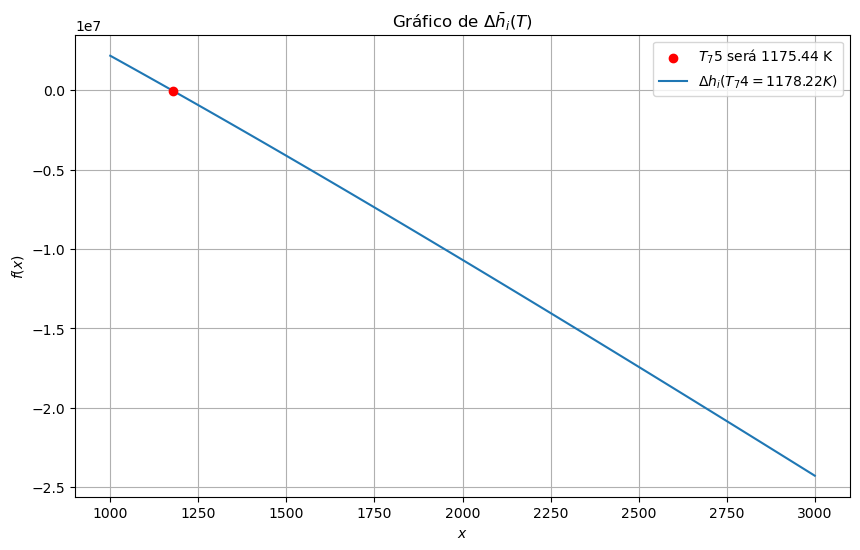

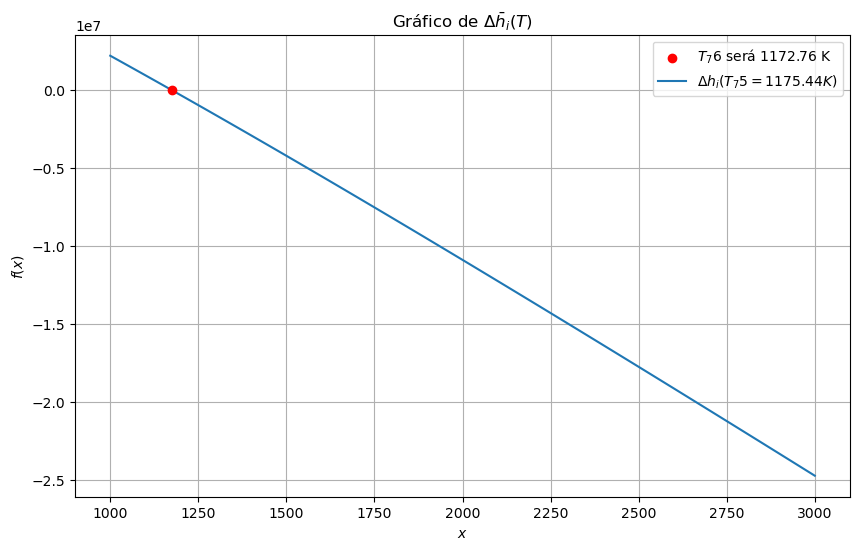

Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de K2CO3(L)


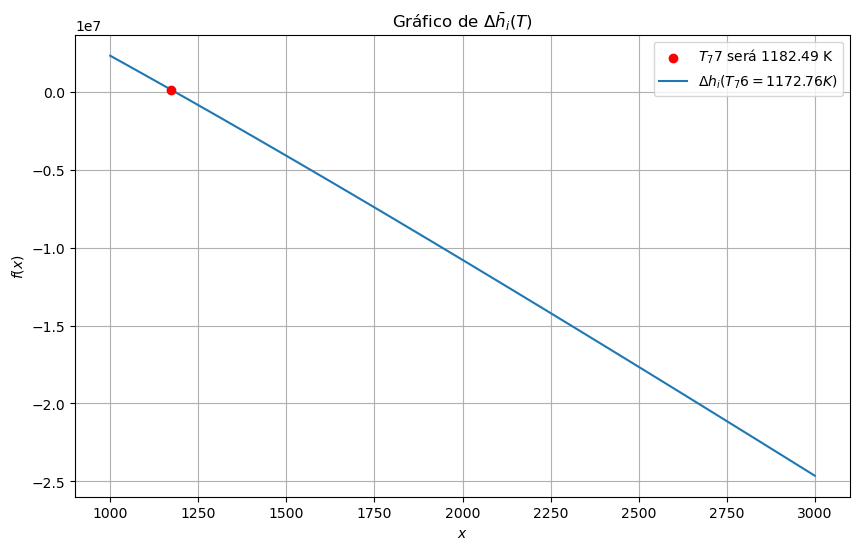

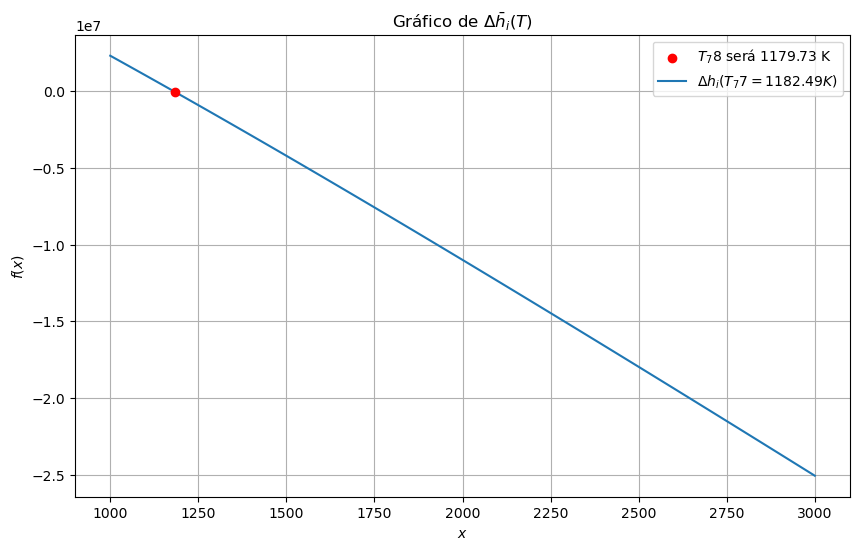

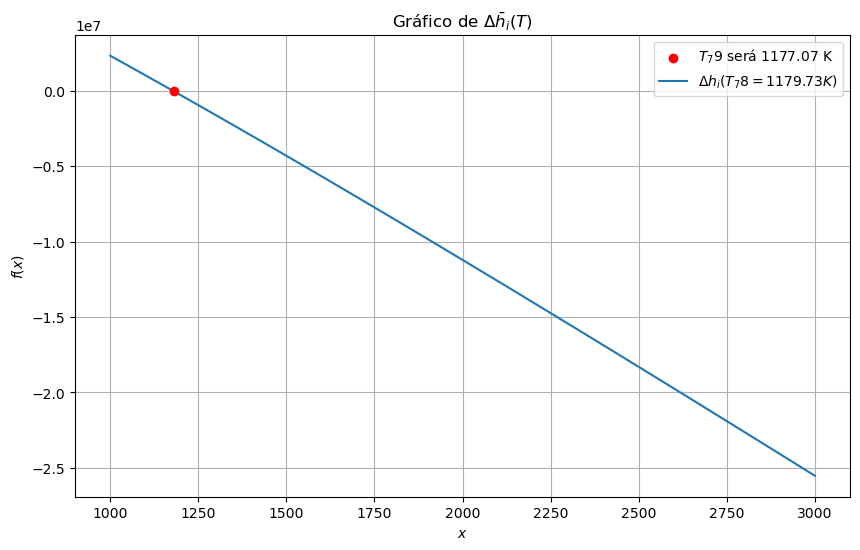

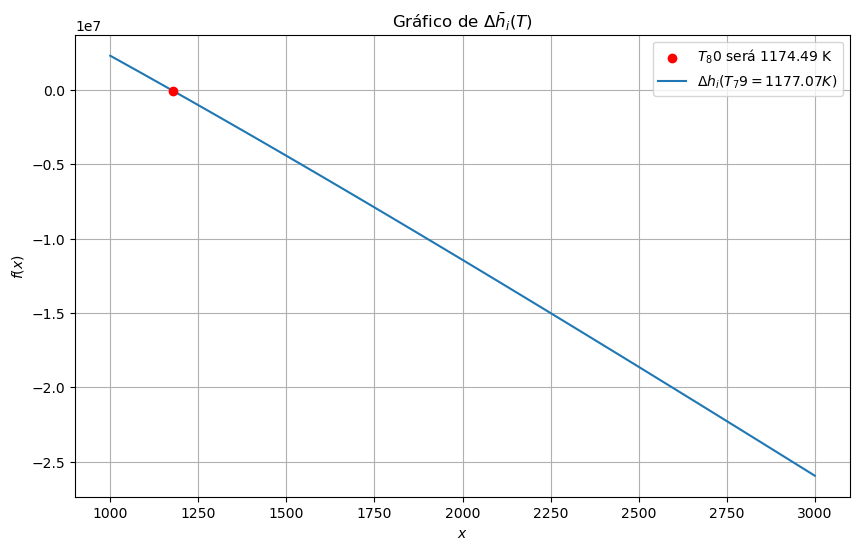

KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
import math

def NewtonRaphson(T_int_3, a_i_1, a_i_2, a_i_ng, x0, tolerance, Especies):
# Convertir x0 a flotante para cálculos numéricos
    x0 = float(x0)
    tramo = abs(2*tolerance)
    tabla = []

    T_0 = 298.15 # K

    cont = 0

    xi = sp.symbols('xi')  # Define xi como símbolo

    fx_ = 0
    dfx_ = 0

    while tramo >= tolerance:
        for index, i in enumerate(Especies):
            if any(ng in i for ng in indent_nogas): #si no es una especie gaseosa
                if  T_int_3[index][1] > x0:
                    print(f'Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de {i}')
                    break 
                elif x0 == T_int_3[index][1]:
                    a_i = a_i_ng[index]
                elif T_int_3[index][1] < x0 < T_int_3[index][2]:
                    a_i = a_i_ng[index]
                elif  T_int_3[index][2] < x0:
                    print(x0)
                    print(f'Temperatura fuera de rango (superior al intervalo válido de la especie), elija otra fase de {i}')
                    break 
                else:
                    print(T_int_3[index][0],T_int_3[index][1],T_int_3[index][2])
                    print(x0)
                    print(f'Temperatura fuera de rango (valor no encontrado) elija otra fase de {i}')
                    break  
                
                H_0 = -a_i[0]/T_0 + a_i[1]*math.log(T_0) + a_i[2]*T_0 + a_i[3]*(T_0**2)/2 + a_i[4]*(T_0**3)/3 + a_i[5]*(T_0**4)/4 + a_i[6]*(T_0**5)/5
            # Actualización de fx_i y dfx_i usando xi 
                fx_i = -coef_p[index]* R *(-a_i[0]/xi + a_i[1]*sp.log(xi) + a_i[2]*xi + a_i[3]*(xi**2)/2 + a_i[4]*(xi**3)/3 + a_i[5]*(xi**4)/4 + a_i[6]*(xi**5)/5 - H_0)
                dfx_i = -coef_p[index]* R *(a_i[0]/(xi**2) + a_i[1]/xi + a_i[2] + a_i[3]*xi + a_i[4]*(xi**2) + a_i[5]*(xi**3) + a_i[6]*(xi**4))

                fx_ += fx_i
                dfx_ += dfx_i

            else: # si es especie gaseosa
                if  T_int_3[index][0] < x0 < T_int_3[index][1]:
                    a_i = a_i_1[index]
                elif x0 == T_int_3[index][1]:
                    a_i = a_i_1[index]
                elif T_int_3[index][1] < x0 < T_int_3[index][2]:
                    a_i = a_i_2[index]
                else:
                    print(f'Temperatura (T={x0}K) fuera de rango de {i}')
                    break  
                
                H_0 = -a_i[0]/T_0 + a_i[1]*math.log(T_0) + a_i[2]*T_0 + a_i[3]*(T_0**2)/2 + a_i[4]*(T_0**3)/3 + a_i[5]*(T_0**4)/4 + a_i[6]*(T_0**5)/5
            # Actualización de fx_i y dfx_i usando xi 
                fx_i = -coef_p[index]* R *(-a_i[0]/xi + a_i[1]*sp.log(xi) + a_i[2]*xi + a_i[3]*(xi**2)/2 + a_i[4]*(xi**3)/3 + a_i[5]*(xi**4)/4 + a_i[6]*(xi**5)/5 - H_0)
                dfx_i = -coef_p[index]* R *(a_i[0]/(xi**2) + a_i[1]/xi + a_i[2] + a_i[3]*xi + a_i[4]*(xi**2) + a_i[5]*(xi**3) + a_i[6]*(xi**4))

                fx_ += fx_i
                dfx_ += dfx_i

        fx_ = hf_ + fx_  # ahora las sumo, porque un poco más arriba porque fx_i va con un -, es decir, se resta

        # Incremento en el contador
        cont += 1

        # Definiendo funciones lambda para evaluación numérica
        fx = sp.lambdify(xi, fx_, 'numpy')
        dfx = sp.lambdify(xi, dfx_, 'numpy')

        # Resolvemos la iteración
        xnuevo = x0 - fx(x0)/dfx(x0)
        tramo = abs(xnuevo - x0)
        tabla.append([x0, xnuevo, tramo])
        x0_ = x0        # solo lo uso para la leyenda y la gráfica (nada más)
        x0 = xnuevo

        # Rango de valores para x y f(x)
        x_vals = np.linspace(1000, 3000, 100)
        y_vals = fx(x_vals)

        # Definimos el punto de iteración
        x_punto = x0_
        y_punto = fx(x0_)

        plt.figure(figsize=(10, 6))
        plt.scatter(x_punto, y_punto, color='red', label=f'$T_{cont+1}$ será {round(x0,ndigits=2)} K', zorder=3)
        plt.plot(x_vals, y_vals, label=f'$\Delta h_i(T_{cont} = {round(x0_,ndigits=2)}K)$')
        plt.title('Gráfico de $\\Delta\\bar{h}_i(T)$')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.legend()
        plt.grid(True)
        plt.show()

    return x0, tabla

x0 = 2000
tolerance = 0.001

NewtonRaphson(T_int_3, a_i_1, a_i_2, a_i_ng, x0, tolerance, Productos)

Temperatura (T=190.8441834676255K) fuera de rango de KOH
Temperatura (T=-20.64376243760674K) fuera de rango de KOH


<lambdifygenerated-9>:2: RuntimeWarning: invalid value encountered in log
  return 1.23406034590183e-14*xi**5 - 2.95095377413514e-10*xi**4 + 2.7444936534925e-6*xi**3 - 0.0134491168136969*xi**2 - 173.539919646958*xi + 44848.5757397832*log(xi) - 345128.179566706 + 14047127.6049057/xi
<lambdifygenerated-11>:2: RuntimeWarning: invalid value encountered in log
  return 1.23406034590183e-14*xi**5 - 2.95095377413514e-10*xi**4 + 2.7444936534925e-6*xi**3 - 0.0134491168136969*xi**2 - 173.539919646958*xi + 44848.5757397832*log(xi) - 392803.586488514 + 14047127.6049057/xi


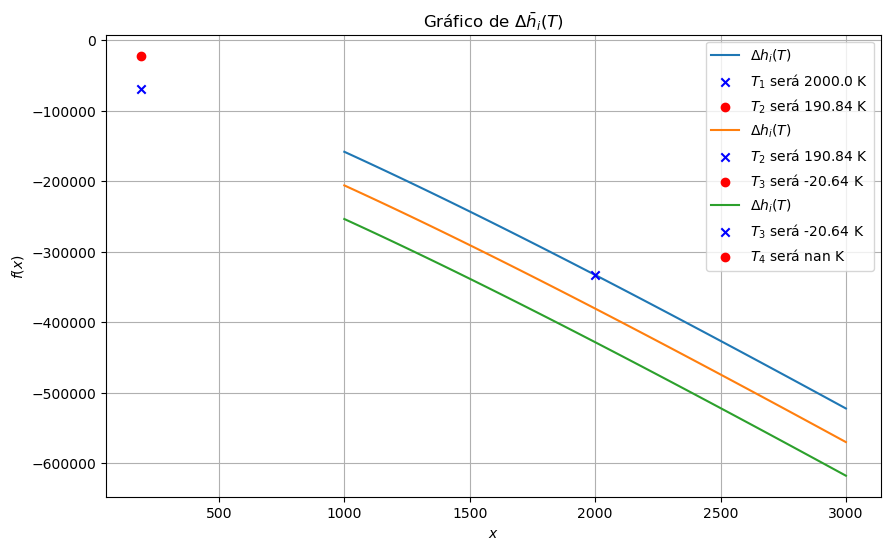

(nan,
 [[2000.0, 190.8441834676255, 1809.1558165323745],
  [190.8441834676255, -20.64376243760674, 211.48794590523224],
  [-20.64376243760674, nan, nan]])

In [3]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
import math

def NewtonRaphson(T_int_3, a_i_1, a_i_2, a_i_ng, x0, tolerance, Especies):
# Convertir x0 a flotante para cálculos numéricos
    x0 = float(x0)
    tramo = abs(2*tolerance)
    tabla = []

    T_0 = 298.15 # K

    cont = 0

    xi = sp.symbols('xi')  # Define xi como símbolo

    fx_ = 0
    dfx_ = 0

    plt.figure(figsize=(10, 6))

    while tramo >= tolerance:
        for index, i in enumerate(Especies):
            if any(ng in i for ng in indent_nogas): #si no es una especie gaseosa
                if  T_int_3[index][1] > x0:
                    print(f'Temperatura fuera de rango (inferior al intervalo de la especie), elija otra fase de {i}')
                    break 
                elif x0 == T_int_3[index][1]:
                    a_i = a_i_ng[index]
                elif T_int_3[index][1] < x0 < T_int_3[index][2]:
                    a_i = a_i_ng[index]
                elif  T_int_3[index][2] < x0:
                    print(x0)
                    print(f'Temperatura fuera de rango (superior al intervalo válido de la especie), elija otra fase de {i}')
                    break 
                else:
                    print(T_int_3[index][0],T_int_3[index][1],T_int_3[index][2])
                    print(x0)
                    print(f'Temperatura fuera de rango (valor no encontrado) elija otra fase de {i}')
                    break  
                
                H_0 = -a_i[0]/T_0 + a_i[1]*math.log(T_0) + a_i[2]*T_0 + a_i[3]*(T_0**2)/2 + a_i[4]*(T_0**3)/3 + a_i[5]*(T_0**4)/4 + a_i[6]*(T_0**5)/5
            # Actualización de fx_i y dfx_i usando xi 
                fx_i = -coef_p[index]* R *(-a_i[0]/xi + a_i[1]*sp.log(xi) + a_i[2]*xi + a_i[3]*(xi**2)/2 + a_i[4]*(xi**3)/3 + a_i[5]*(xi**4)/4 + a_i[6]*(xi**5)/5 - H_0)
                dfx_i = -coef_p[index]* R *(a_i[0]/(xi**2) + a_i[1]/xi + a_i[2] + a_i[3]*xi + a_i[4]*(xi**2) + a_i[5]*(xi**3) + a_i[6]*(xi**4))

                fx_ += fx_i
                dfx_ += dfx_i

            else: # si es especie gaseosa
                if  T_int_3[index][0] < x0 < T_int_3[index][1]:
                    a_i = a_i_1[index]
                elif x0 == T_int_3[index][1]:
                    a_i = a_i_1[index]
                elif T_int_3[index][1] < x0 < T_int_3[index][2]:
                    a_i = a_i_2[index]
                else:
                    print(f'Temperatura (T={x0}K) fuera de rango de {i}')
                    break  
                
                H_0 = -a_i[0]/T_0 + a_i[1]*math.log(T_0) + a_i[2]*T_0 + a_i[3]*(T_0**2)/2 + a_i[4]*(T_0**3)/3 + a_i[5]*(T_0**4)/4 + a_i[6]*(T_0**5)/5
            # Actualización de fx_i y dfx_i usando xi 
                fx_i = -coef_p[index]* R *(-a_i[0]/xi + a_i[1]*sp.log(xi) + a_i[2]*xi + a_i[3]*(xi**2)/2 + a_i[4]*(xi**3)/3 + a_i[5]*(xi**4)/4 + a_i[6]*(xi**5)/5 - H_0)
                dfx_i = -coef_p[index]* R *(a_i[0]/(xi**2) + a_i[1]/xi + a_i[2] + a_i[3]*xi + a_i[4]*(xi**2) + a_i[5]*(xi**3) + a_i[6]*(xi**4))

                fx_ += fx_i
                dfx_ += dfx_i

        fx_ = hf_ + fx_  # ahora las sumo, porque un poco más arriba porque fx_i va con un -, es decir, se resta

        # Incremento en el contador
        cont += 1

        # Definiendo funciones lambda para evaluación numérica
        fx = sp.lambdify(xi, fx_, 'numpy')
        dfx = sp.lambdify(xi, dfx_, 'numpy')

        # Resolvemos la iteración
        xnuevo = x0 - fx(x0)/dfx(x0)
        tramo = abs(xnuevo - x0)
        tabla.append([x0, xnuevo, tramo])
        x0_ = x0        # solo lo uso para la leyenda y la gráfica (nada más)
        x0 = xnuevo

        # Rango de valores para x y f(x)
        x_vals = np.linspace(1000, 3000, 100)
        y_vals = fx(x_vals)

        y_vals_dx = dfx(x_vals)

        # Definimos el punto usado en la iteración
        x_punto_ = x0_
        y_punto_ = fx(x0_)

        # Definimos el punto siguiente de iteración
        x_punto = x0
        y_punto = fx(x0)

        plt.plot(x_vals, y_vals, label=f'$\Delta h_i(T)$')
        plt.scatter(x_punto_, y_punto_, color='blue', marker='x', label=f'$T_{cont}$ será {round(x0_,ndigits=2)} K', zorder=3)
        plt.scatter(x_punto, y_punto, color='red', label=f'$T_{cont+1}$ será {round(x0,ndigits=2)} K', zorder=3)
        plt.title('Gráfico de $\\Delta\\bar{h}_i(T)$')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.legend()
        plt.grid(True)
    
    plt.show()

    return x0, tabla

x0 = 2000
tolerance = 0.001

NewtonRaphson(T_int_3, a_i_1, a_i_2, a_i_ng, x0, tolerance, Productos)


In [4]:
# probando funciones de entalpía sensible de cada especie
print(Productos)
T_control = 2000 # K

datos_especie = a_i_1[3]

hs_298_15 = H_H0(8.314,298.15,datos_especie)
hs_control = H_H0(8.314,298.16,datos_especie)
print(f'h_s_298.15 = {hs_298_15} J/mol (si no es 0 no vale)')
print(f'h_s_{T_control} = {hs_control} J/mol (debe ser distinto de 0)')

['CO', 'CO2', 'H2O', 'H2', 'N2', 'KOH(L)', 'K2CO3(L)']
h_s_298.15 = 0.0 J/mol (si no es 0 no vale)
h_s_2000 = 0.28834612994661984 J/mol (debe ser distinto de 0)
